In [1]:
import numpy as np
from keras import backend as K
import gc
import matplotlib.pyplot as plt
import seaborn
from keras.datasets import cifar10
%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 970M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5110)


In [2]:
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Dense, Activation, Input
from keras.layers.normalization import BatchNormalization
from keras.engine import InputSpec, Layer, Merge
from keras.optimizers import SGD, Adam, Adagrad
from keras.utils import np_utils

In [3]:
import sys
sys.setrecursionlimit(10000)

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
nb_classes = 10
nb_epoch = 10

# input image dimensions
img_rows, img_cols = 32, 32
# the CIFAR10 images are RGB
img_channels = 3

# the data, shuffled and split between train and test sets
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


In [6]:
X_train = X_train.reshape(50000, img_channels*img_rows*img_cols).astype('float32')
X_test = X_test.reshape(10000, img_channels*img_rows*img_cols).astype('float32')

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
 class NP_Relu(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        self.c1 = np.float32(np.sqrt(0.5 * (1 - 1 / np.pi)))
        self.c2 = np.float32(1 / np.sqrt(2 * np.pi))
        super(NP_Relu, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W = self.add_weight(shape=(input_shape[1], self.output_dim),
                                 initializer='orthogonal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.output_dim),
                                 initializer='zero',
                                 trainable=True)       
        self.g = self.add_weight(shape=(self.output_dim),
                                 initializer=self.my_init,
                                 trainable=True)
        super(NP_Relu, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x, mask=None):
        normalize = K.l2_normalize(self.W, 0)
        output = self.g*K.dot(x, normalize) + self.b
        return (K.relu(output)-self.c2)/self.c1

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def my_init(self, shape, name=None):
        value = 1/1.21 * np.ones(shape)
        return K.variable(value, name=name)

In [9]:
class NN:
    def __init__(self, n_layers, n_neurons, optimizer):
        inputs = Input(shape=(img_channels*img_rows*img_cols,))
        f_activations = [inputs]
        for i in range(n_layers):
            hid1 = Dense(n_neurons, activation='relu')(f_activations[-1])
            f_activations.append(hid1)

        predictions = Dense(10, activation='softmax', bias=True)(f_activations[-1])
        #activations.append(predictions)
        self.model = Model(input=inputs, output=predictions)
        self.intermidiate_models = [Model(input=inputs, output=f_activations[i]) for i in range(n_layers+1)]
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    def fit(self, verbose_level=1, batch_size=512):
        self.history = self.model.fit(X_train, Y_train, batch_size=batch_size, 
                            nb_epoch=10, verbose=verbose_level, validation_data=(X_test, Y_test))
        
    def draw_activations(self):
        choice = np.random.choice(X_test.shape[0], 150, replace=False)
        pred = [m.predict(X_test[choice]) for m in self.intermidiate_models]
        outs = np.array([[p.mean(axis=0).mean(), p.std(axis=0).mean()] for p in pred])
        plt.figure(figsize=(20,6))
        plt.plot(range(outs.shape[0]), outs[:,0], label='mean')
        plt.plot(range(outs.shape[0]), outs[:,1], label='std')
        plt.xticks(range(outs.shape[0]))
        plt.xlabel('layer')
        plt.ylabel('activation')
        plt.legend()

In [10]:
nn = NN(5, 100, Adam(lr=1e-3))

In [18]:
nn.model.get_weights()[2].shape

(100, 100)

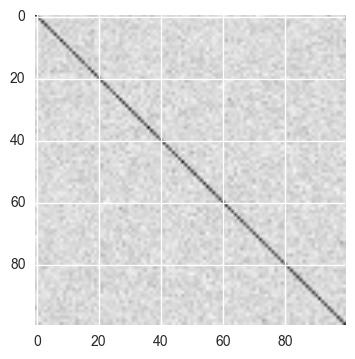

In [30]:
plt.imshow(nn.model.get_weights()[8].T.dot(nn.model.get_weights()[8]))

In [10]:
class NN_BN(NN):
    def __init__(self, n_layers, n_neurons, optimizer):
        inputs = Input(shape=(img_channels*img_rows*img_cols,))
        f_activations = [inputs]
        for i in range(n_layers):
            hid1 = Dense(n_neurons)(f_activations[-1])
            bn1 = BatchNormalization()(hid1)
            act1 = Activation('relu')(bn1)
            f_activations.append(act1)

        predictions = Dense(10, activation='softmax', bias=True)(f_activations[-1])
        #activations.append(predictions)
        self.model = Model(input=inputs, output=predictions)
        self.intermidiate_models = [Model(input=inputs, output=f_activations[i]) for i in range(n_layers+1)]
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [11]:
class NN_NP(NN):
    def __init__(self, n_layers, n_neurons, optimizer):
        inputs = Input(shape=(img_channels*img_rows*img_cols,))
        f_activations = [inputs]
        for i in range(n_layers):
            hid1 = NP_Relu(n_neurons)(f_activations[-1])
            f_activations.append(hid1)

        predictions = Dense(10, activation='softmax', bias=True)(f_activations[-1])
        #activations.append(predictions)
        self.model = Model(input=inputs, output=predictions)
        self.intermidiate_models = [Model(input=inputs, output=f_activations[i]) for i in range(n_layers+1)]
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Пробный запуск

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1s - loss: 1.7816 - acc: 0.3654 - val_loss: 1.5988 - val_acc: 0.4328
Epoch 2/10
50000/50000 [==============================] - 1s - loss: 1.5309 - acc: 0.4574 - val_loss: 1.5128 - val_acc: 0.4646
Epoch 3/10
50000/50000 [==============================] - 1s - loss: 1.4224 - acc: 0.4985 - val_loss: 1.4599 - val_acc: 0.4852
Epoch 4/10
50000/50000 [==============================] - 1s - loss: 1.3546 - acc: 0.5213 - val_loss: 1.4396 - val_acc: 0.4949
Epoch 5/10
50000/50000 [==============================] - 1s - loss: 1.2794 - acc: 0.5494 - val_loss: 1.4366 - val_acc: 0.5013
Epoch 6/10
50000/50000 [==============================] - 1s - loss: 1.2374 - acc: 0.5642 - val_loss: 1.4259 - val_acc: 0.5051
Epoch 7/10
50000/50000 [==============================] - 1s - loss: 1.1838 - acc: 0.5816 - val_loss: 1.3974 - val_acc: 0.5179
Epoch 8/10
50000/50000 [==============================] - 1s 

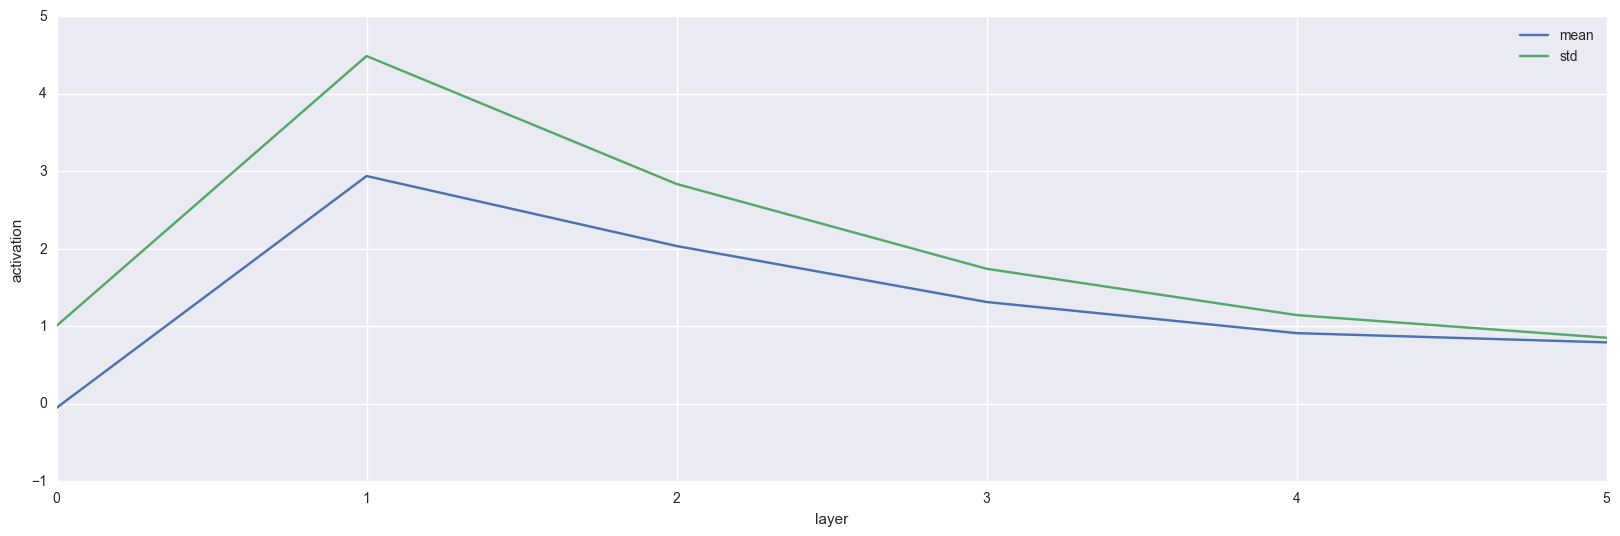

In [12]:
nn = NN(5, 100, Adam(lr=1e-3))
nn.fit(1)
nn.draw_activations()

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1s - loss: 1.7980 - acc: 0.3570 - val_loss: 1.7843 - val_acc: 0.3823
Epoch 2/10
50000/50000 [==============================] - 1s - loss: 1.5107 - acc: 0.4594 - val_loss: 1.5548 - val_acc: 0.4508
Epoch 3/10
50000/50000 [==============================] - 1s - loss: 1.4012 - acc: 0.4994 - val_loss: 1.4683 - val_acc: 0.4796
Epoch 4/10
50000/50000 [==============================] - 1s - loss: 1.3234 - acc: 0.5311 - val_loss: 1.4183 - val_acc: 0.4988
Epoch 5/10
50000/50000 [==============================] - 1s - loss: 1.2583 - acc: 0.5535 - val_loss: 1.4296 - val_acc: 0.4902
Epoch 6/10
50000/50000 [==============================] - 1s - loss: 1.2057 - acc: 0.5745 - val_loss: 1.4088 - val_acc: 0.5031
Epoch 7/10
50000/50000 [==============================] - 1s - loss: 1.1523 - acc: 0.5915 - val_loss: 1.4218 - val_acc: 0.5054
Epoch 8/10
50000/50000 [==============================] - 1s 

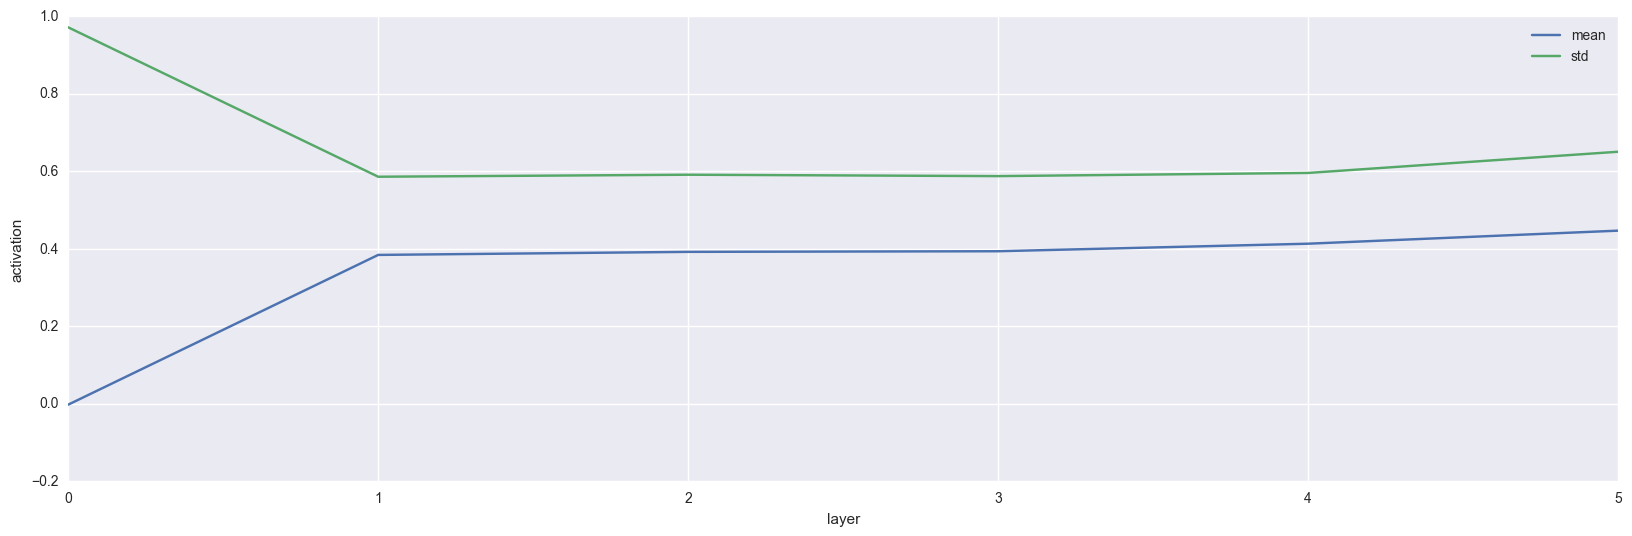

In [13]:
nn = NN_BN(5, 100, Adam(lr=1e-3))
nn.fit(1)
nn.draw_activations()

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1s - loss: 1.8486 - acc: 0.3452 - val_loss: 1.6537 - val_acc: 0.4194
Epoch 2/10
50000/50000 [==============================] - 1s - loss: 1.5673 - acc: 0.4431 - val_loss: 1.5298 - val_acc: 0.4598
Epoch 3/10
50000/50000 [==============================] - 1s - loss: 1.4450 - acc: 0.4848 - val_loss: 1.4842 - val_acc: 0.4730
Epoch 4/10
50000/50000 [==============================] - 1s - loss: 1.3582 - acc: 0.5182 - val_loss: 1.4492 - val_acc: 0.4864
Epoch 5/10
50000/50000 [==============================] - 1s - loss: 1.2868 - acc: 0.5436 - val_loss: 1.4527 - val_acc: 0.4962
Epoch 6/10
50000/50000 [==============================] - 1s - loss: 1.2324 - acc: 0.5634 - val_loss: 1.4414 - val_acc: 0.4979
Epoch 7/10
50000/50000 [==============================] - 1s - loss: 1.1782 - acc: 0.5835 - val_loss: 1.4294 - val_acc: 0.5027
Epoch 8/10
50000/50000 [==============================] - 1s 

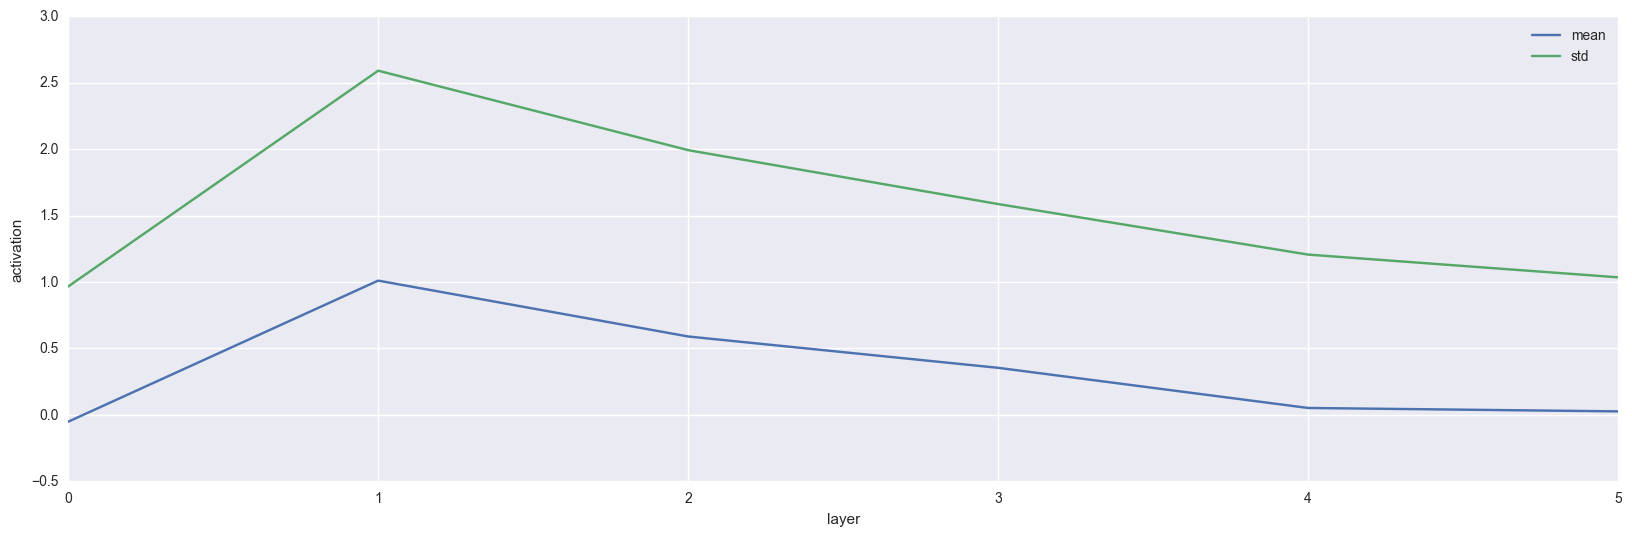

In [14]:
nn = NN_NP(5, 100, Adam(lr=1e-3))
nn.fit(1)
nn.draw_activations()

# Обычная сеть

### SGD(1e-2)

In [26]:
nn = NN(5, 250, SGD(lr=1e-2))
nn.fit(0)

In [27]:
nn2 = NN(15, 250, SGD(lr=1e-2))
nn2.fit(0)

In [28]:
nn3 = NN(35, 250, SGD(lr=1e-2))
nn3.fit(0)

In [29]:
nn4 = NN(45, 250, SGD(lr=1e-2))
nn4.fit(0)

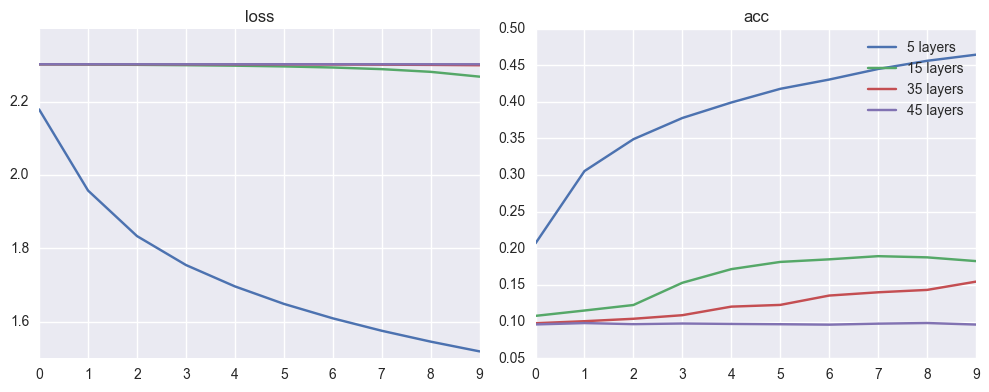

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(nn.history.history['loss'], label='5 layers')
ax1.plot(nn2.history.history['loss'], label='15 layers')
ax1.plot(nn3.history.history['loss'], label='35 layers')
ax1.plot(nn4.history.history['loss'], label='45 layers')
ax1.set_title('loss')
ax2.plot(nn.history.history['acc'], label='5 layers')
ax2.plot(nn2.history.history['acc'], label='15 layers')
ax2.plot(nn3.history.history['acc'], label='35 layers')
ax2.plot(nn4.history.history['acc'], label='45 layers')
ax2.set_title('acc')
plt.legend()
plt.tight_layout()

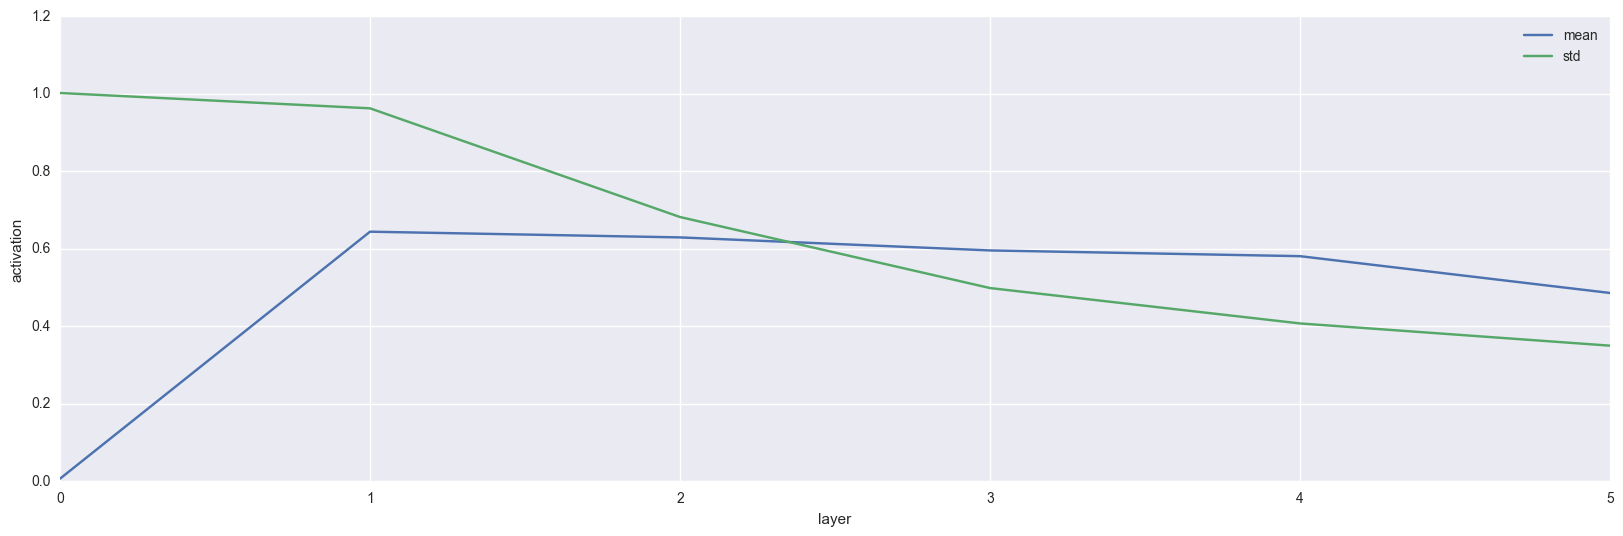

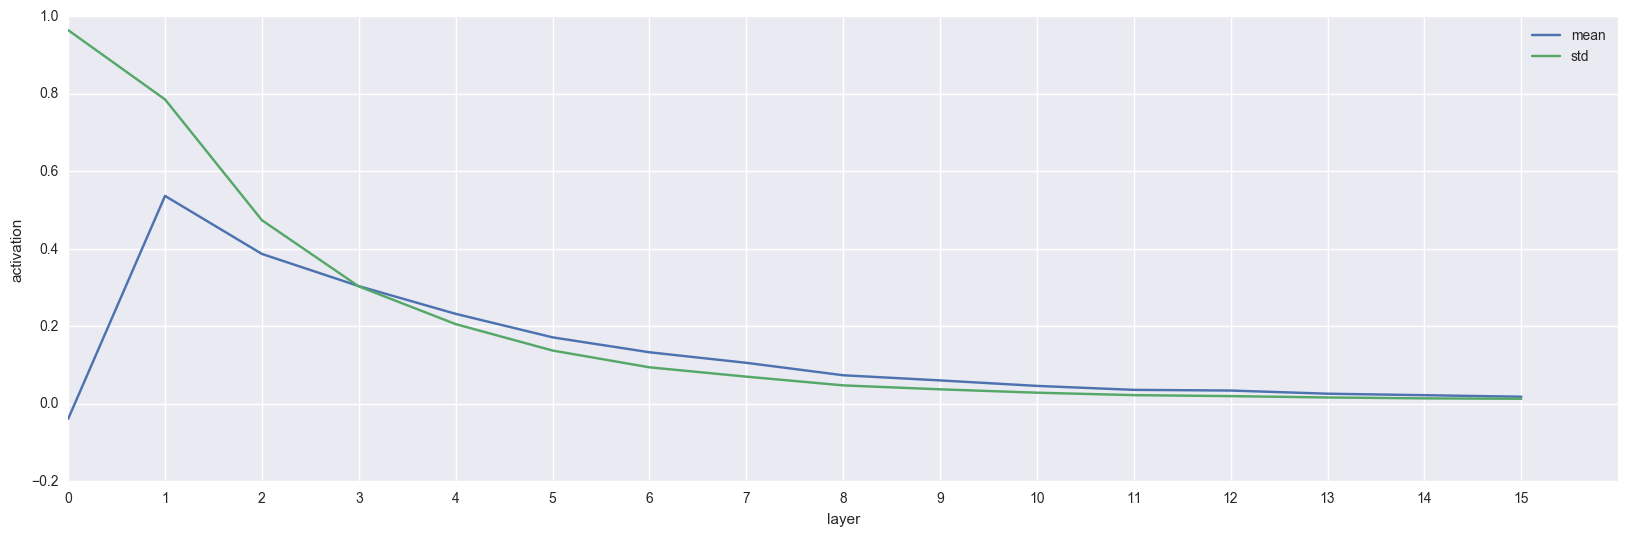

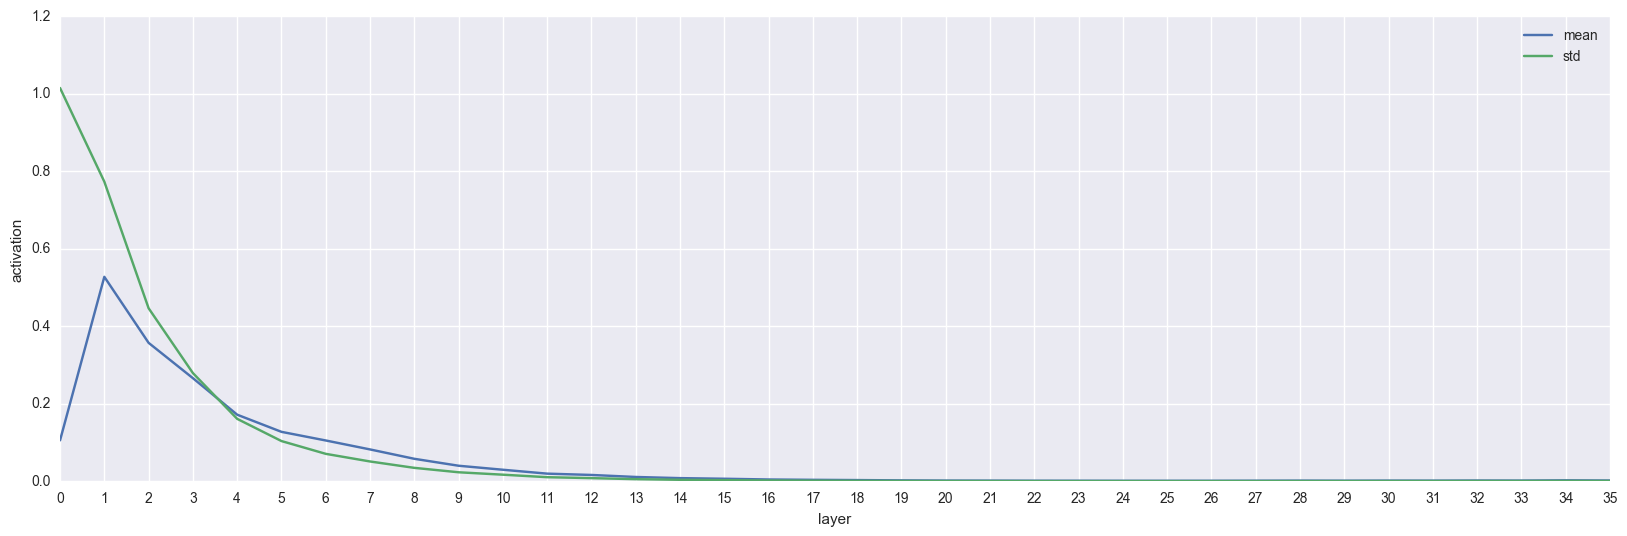

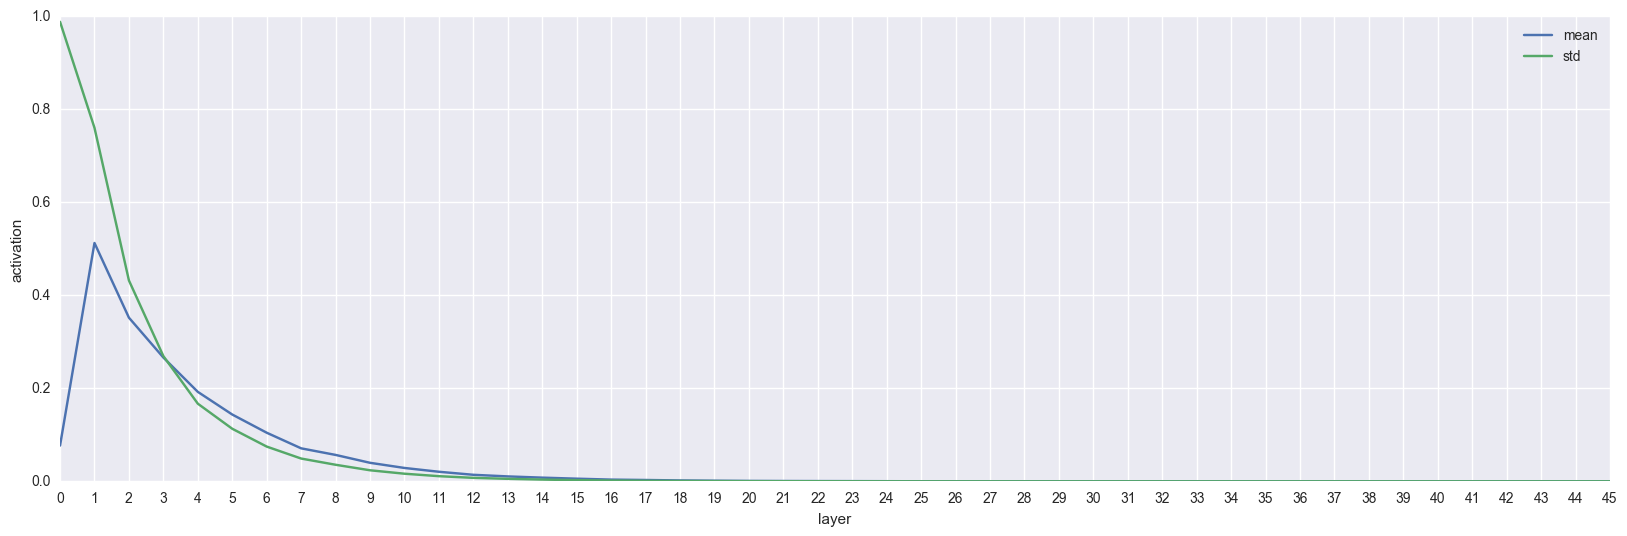

In [30]:
nn.draw_activations()
nn2.draw_activations()
nn3.draw_activations()
nn4.draw_activations()

### SGD(1e-3)

In [44]:
nn = NN(5, 250, SGD(lr=1e-3))
nn.fit(0)

In [45]:
nn2 = NN(15, 250, SGD(lr=1e-3))
nn2.fit(0)

In [46]:
nn3 = NN(35, 250, SGD(lr=1e-3))
nn3.fit(0)

In [47]:
nn4 = NN(45, 250, SGD(lr=1e-3))
nn4.fit(0)

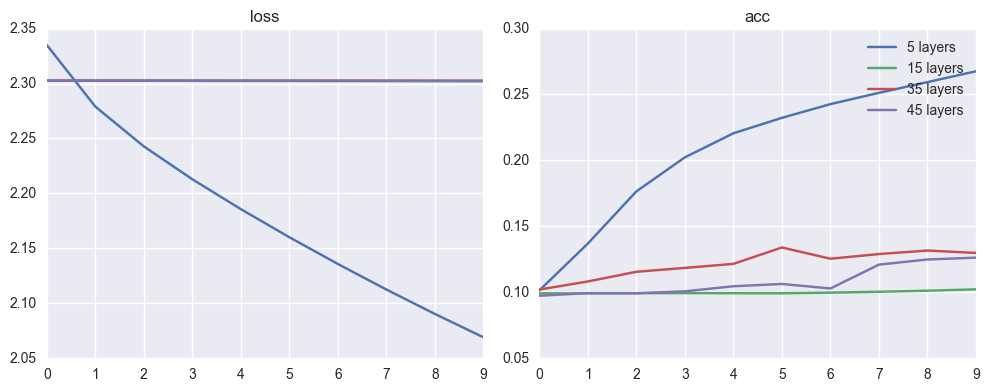

In [48]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(nn.history.history['loss'], label='5 layers')
ax1.plot(nn2.history.history['loss'], label='15 layers')
ax1.plot(nn3.history.history['loss'], label='35 layers')
ax1.plot(nn4.history.history['loss'], label='45 layers')
ax1.set_title('loss')
ax2.plot(nn.history.history['acc'], label='5 layers')
ax2.plot(nn2.history.history['acc'], label='15 layers')
ax2.plot(nn3.history.history['acc'], label='35 layers')
ax2.plot(nn4.history.history['acc'], label='45 layers')
ax2.set_title('acc')
plt.legend()
plt.tight_layout()

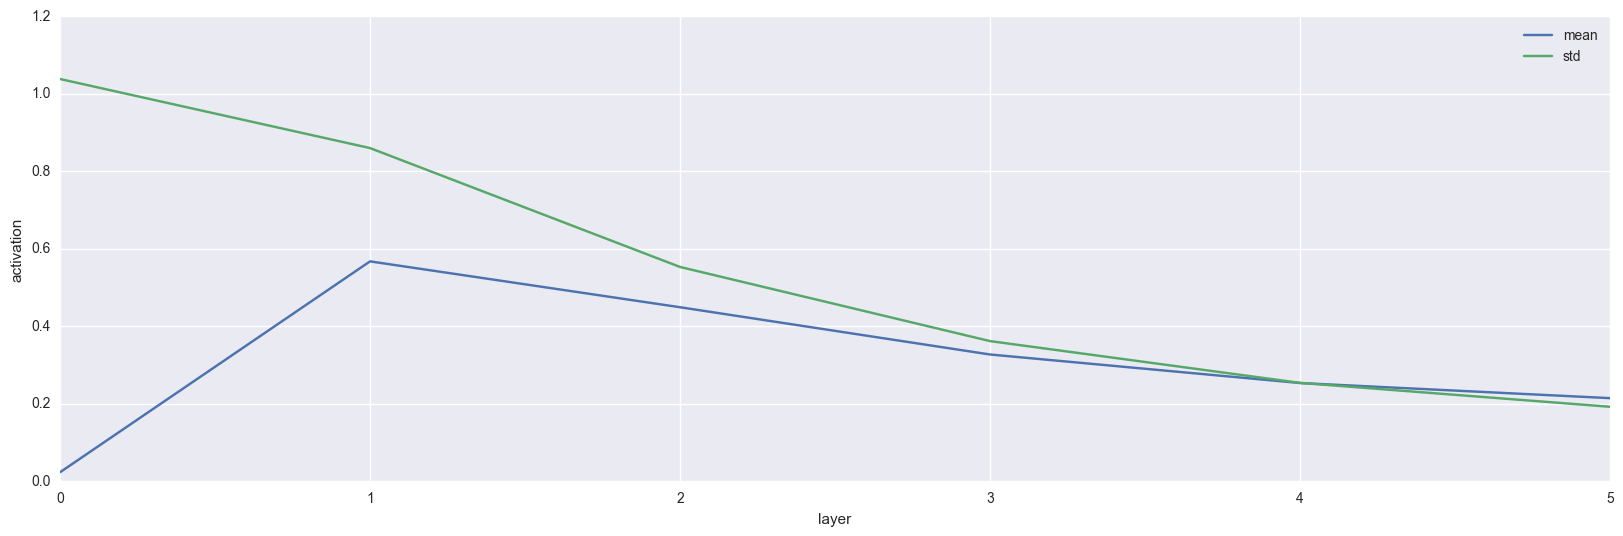

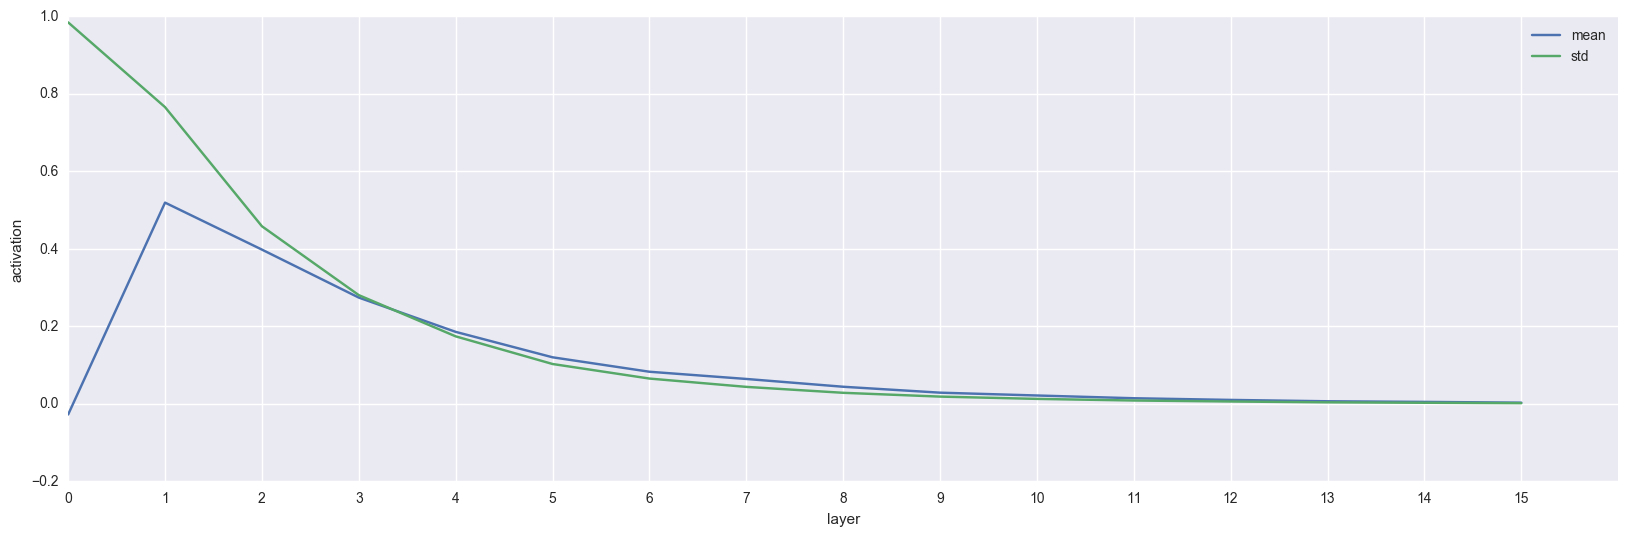

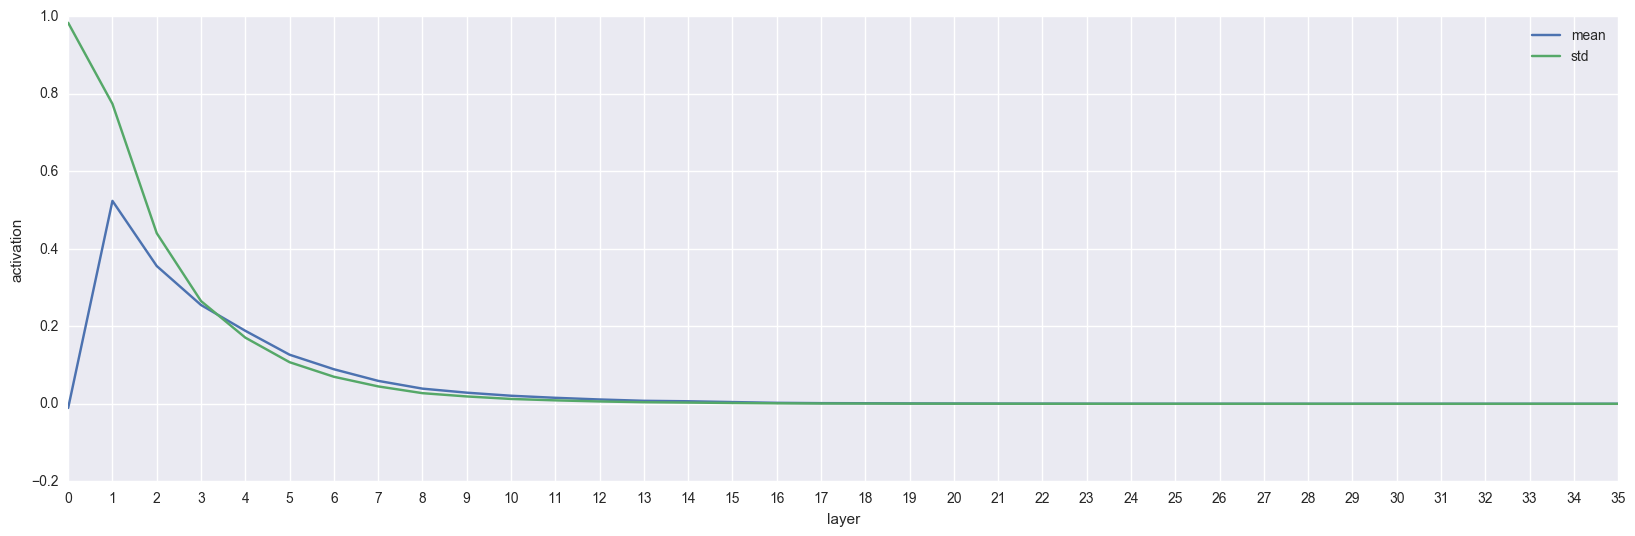

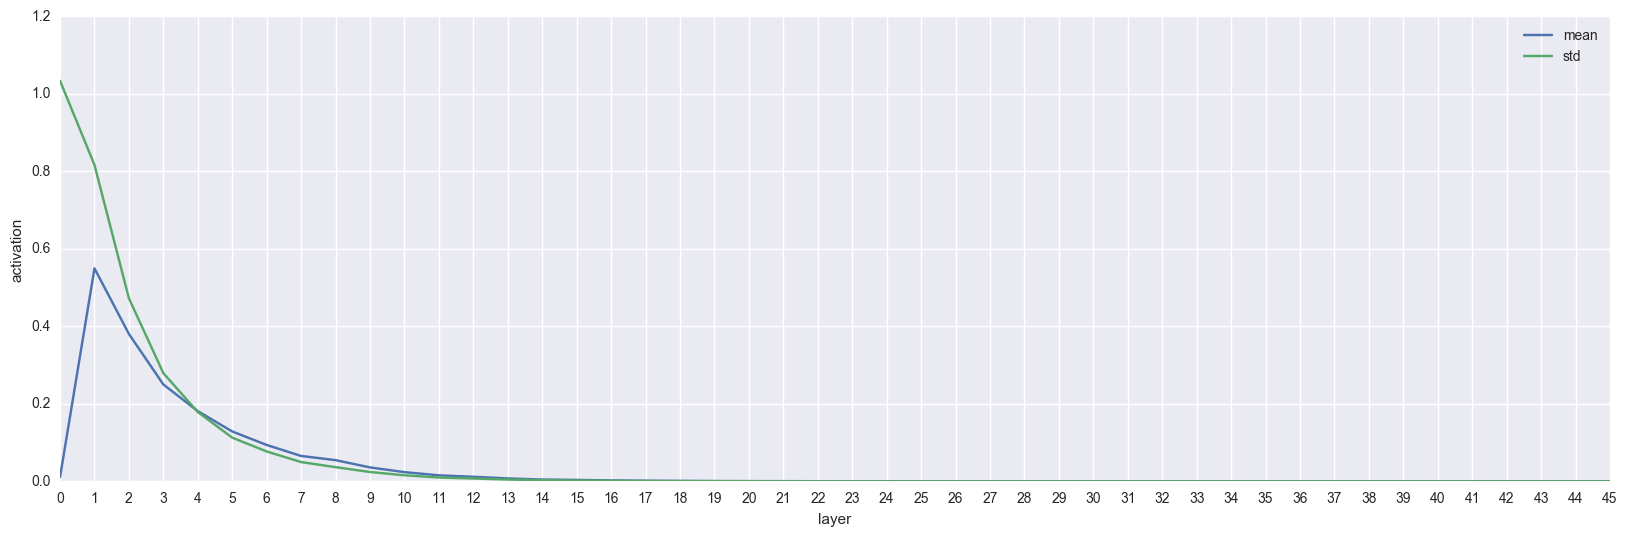

In [49]:
nn.draw_activations()
nn2.draw_activations()
nn3.draw_activations()
nn4.draw_activations()

### Adam(1e-3)

In [53]:
nn = NN(5, 250, Adam(1e-3))
nn.fit(0)

In [54]:
nn2 = NN(15, 250, Adam(1e-3))
nn2.fit(0)

In [55]:
nn3 = NN(35, 250, Adam(1e-3))
nn3.fit(0)

In [56]:
nn4 = NN(45, 250, Adam(1e-3))
nn4.fit(0)

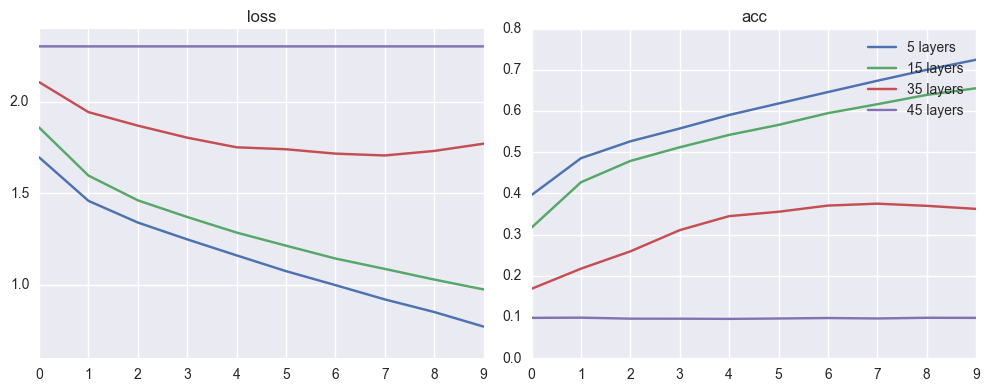

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(nn.history.history['loss'], label='5 layers')
ax1.plot(nn2.history.history['loss'], label='15 layers')
ax1.plot(nn3.history.history['loss'], label='35 layers')
ax1.plot(nn4.history.history['loss'], label='45 layers')
ax1.set_title('loss')
ax2.plot(nn.history.history['acc'], label='5 layers')
ax2.plot(nn2.history.history['acc'], label='15 layers')
ax2.plot(nn3.history.history['acc'], label='35 layers')
ax2.plot(nn4.history.history['acc'], label='45 layers')
ax2.set_title('acc')
plt.legend()
plt.tight_layout()

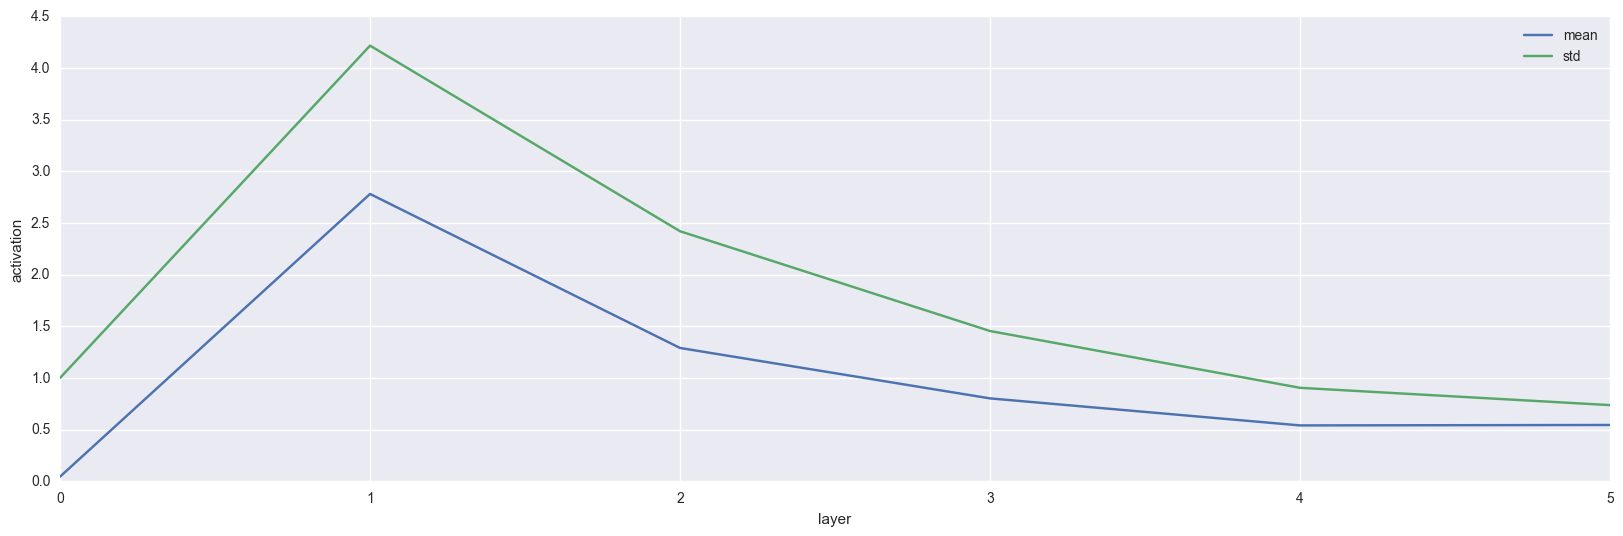

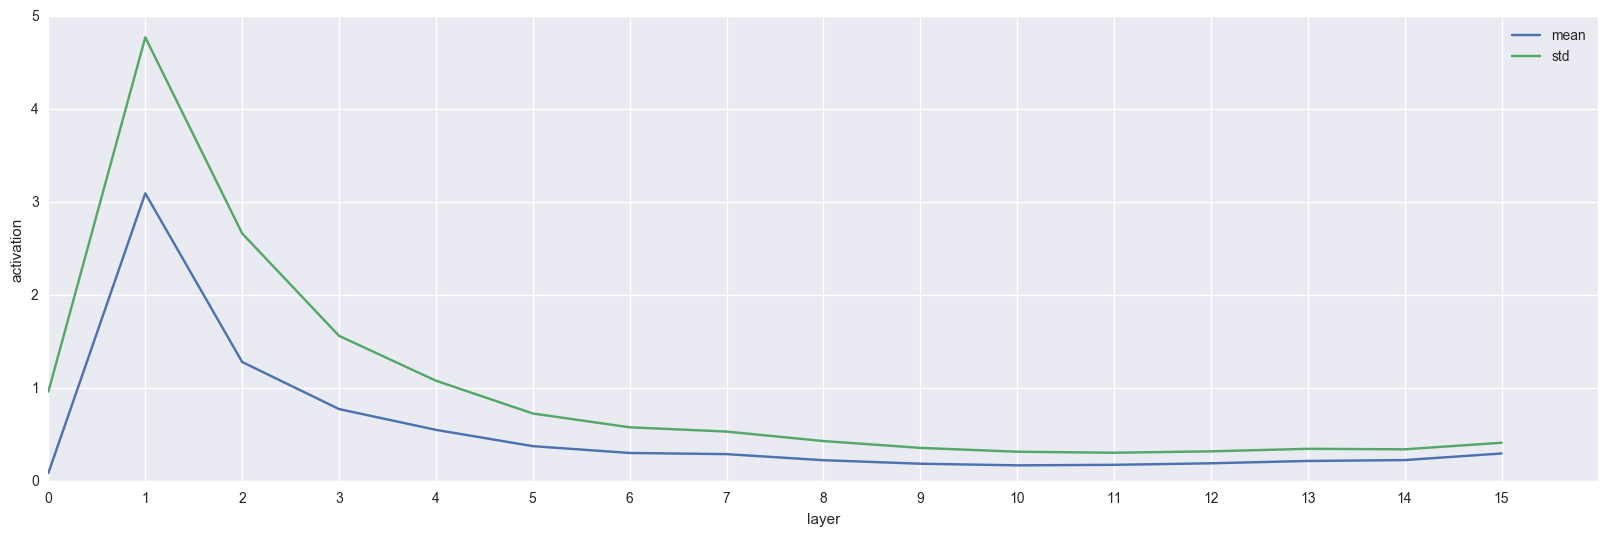

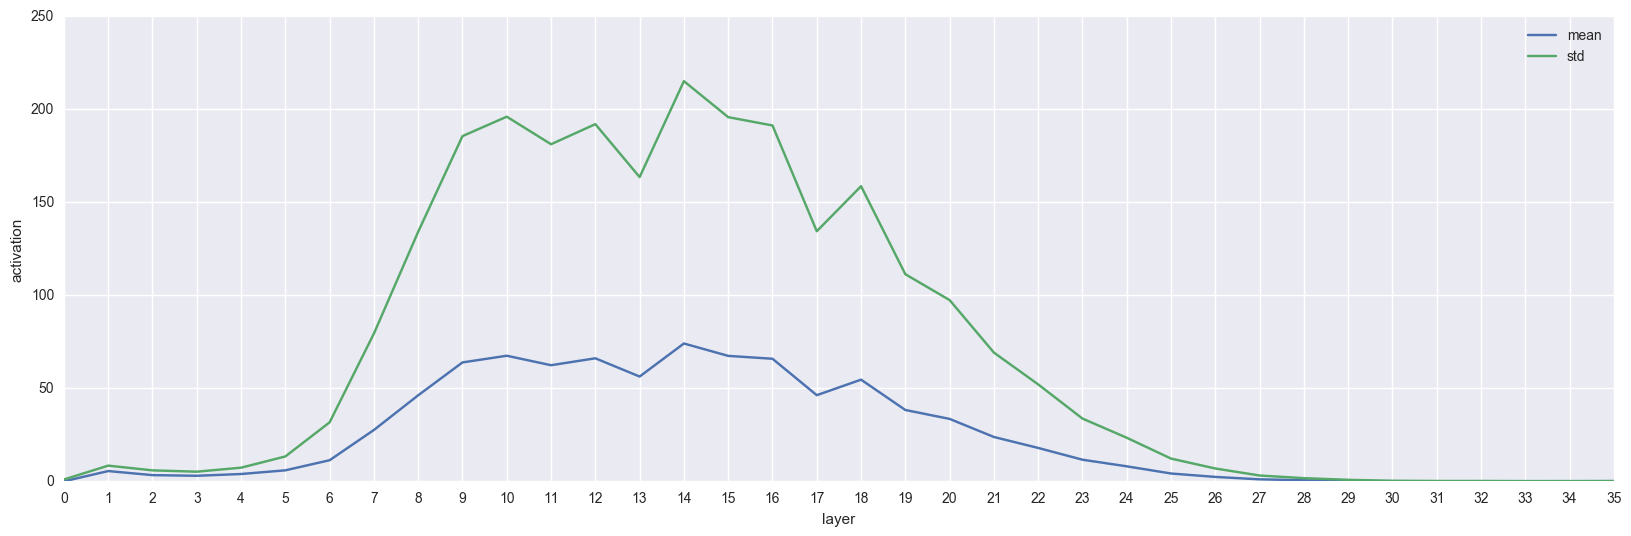

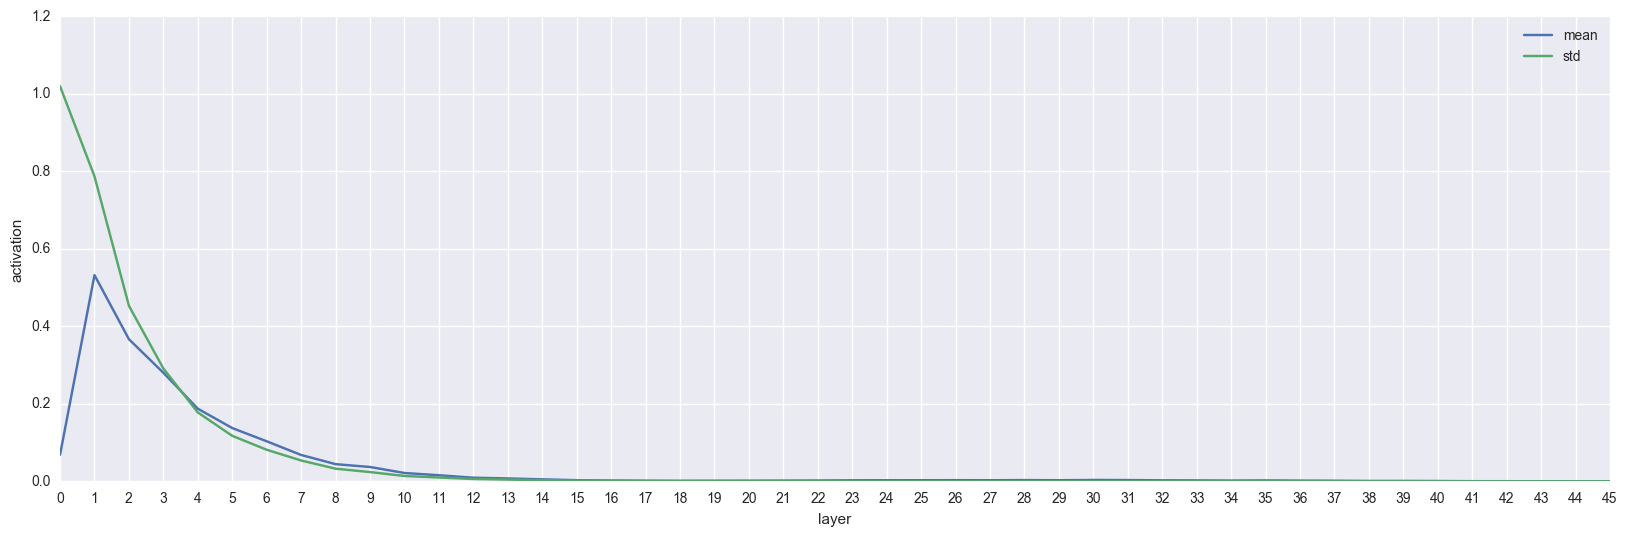

In [58]:
nn.draw_activations()
nn2.draw_activations()
nn3.draw_activations()
nn4.draw_activations()

### Adam(1e-4)

In [59]:
nn = NN(5, 250, Adam(1e-4))
nn.fit(0)

In [60]:
nn2 = NN(15, 250, Adam(1e-4))
nn2.fit(0)

In [61]:
nn3 = NN(35, 250, Adam(1e-4))
nn3.fit(0)

In [62]:
nn4 = NN(45, 250, Adam(1e-4))
nn4.fit(0)

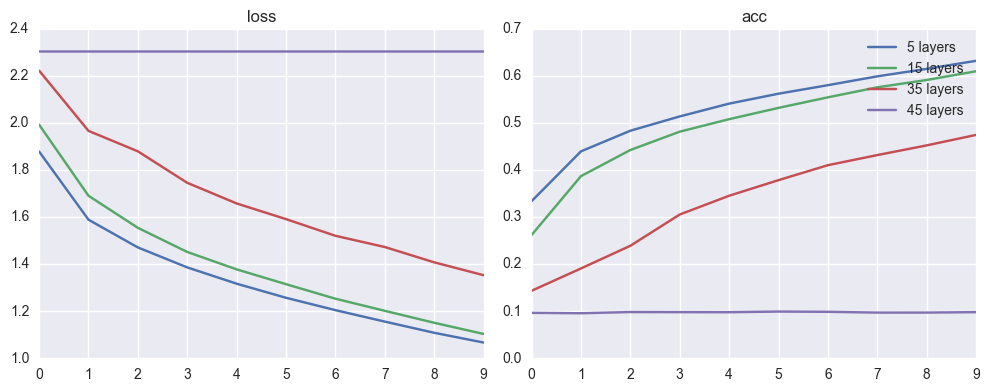

In [63]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(nn.history.history['loss'], label='5 layers')
ax1.plot(nn2.history.history['loss'], label='15 layers')
ax1.plot(nn3.history.history['loss'], label='35 layers')
ax1.plot(nn4.history.history['loss'], label='45 layers')
ax1.set_title('loss')
ax2.plot(nn.history.history['acc'], label='5 layers')
ax2.plot(nn2.history.history['acc'], label='15 layers')
ax2.plot(nn3.history.history['acc'], label='35 layers')
ax2.plot(nn4.history.history['acc'], label='45 layers')
ax2.set_title('acc')
plt.legend()
plt.tight_layout()

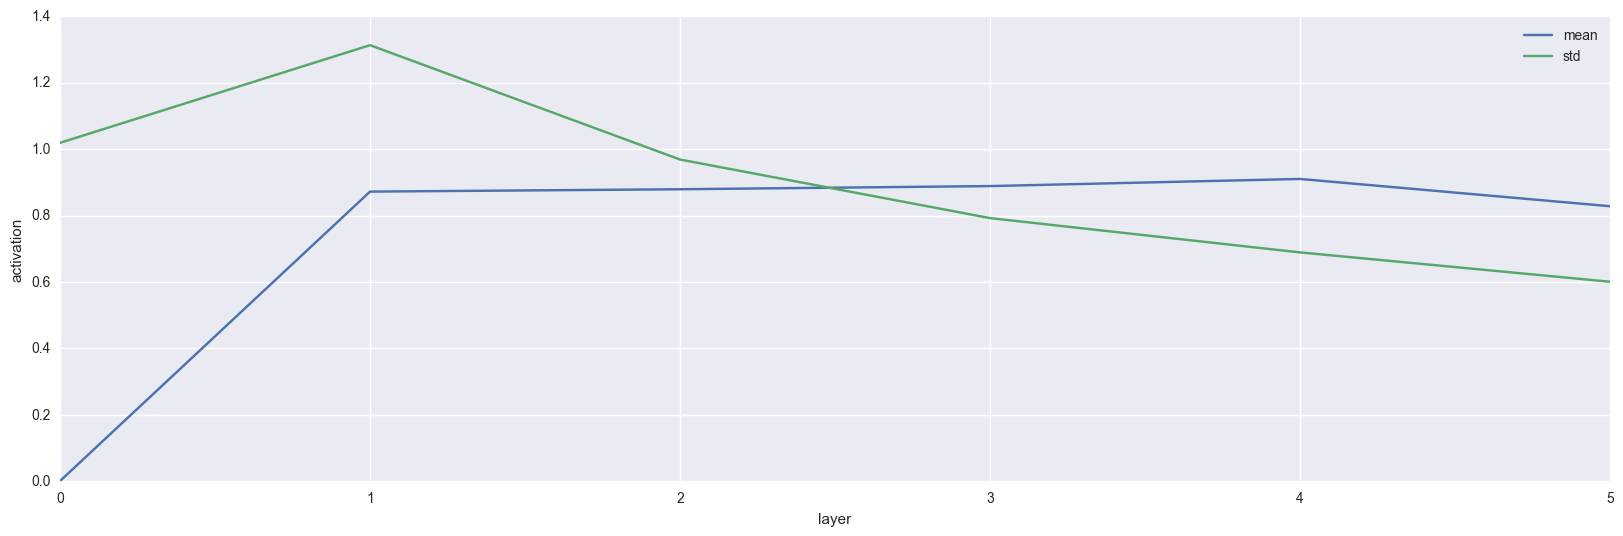

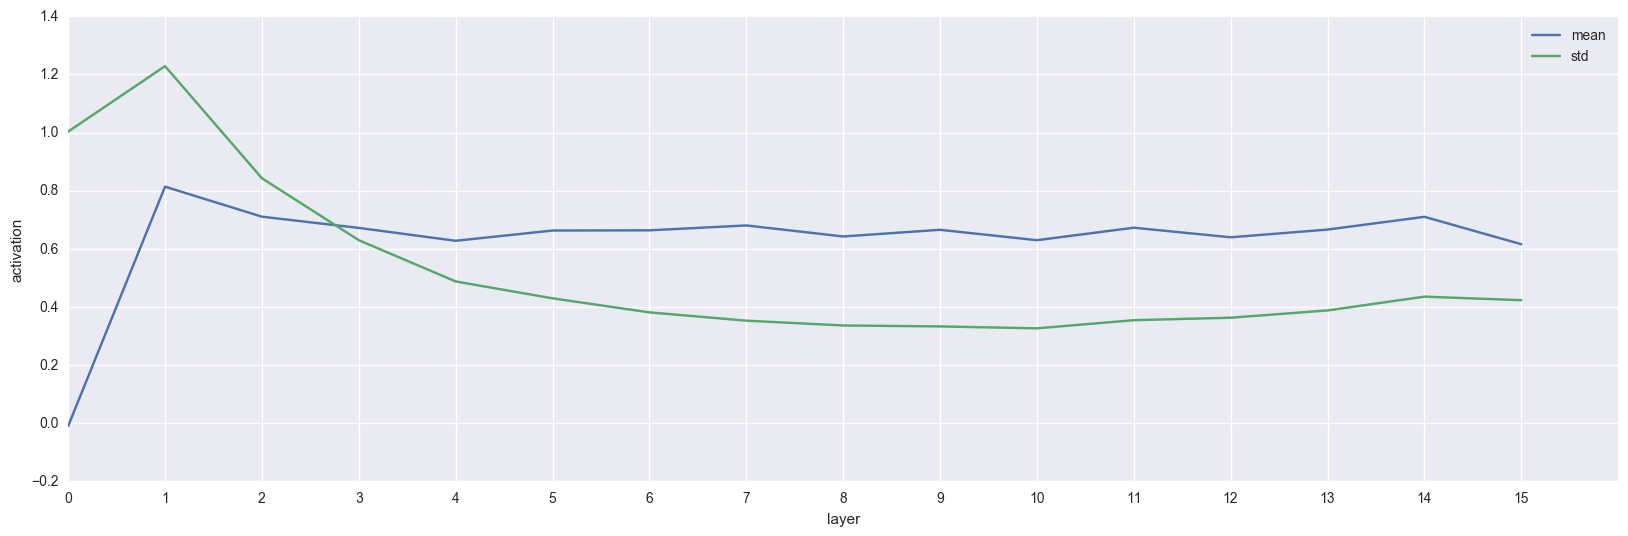

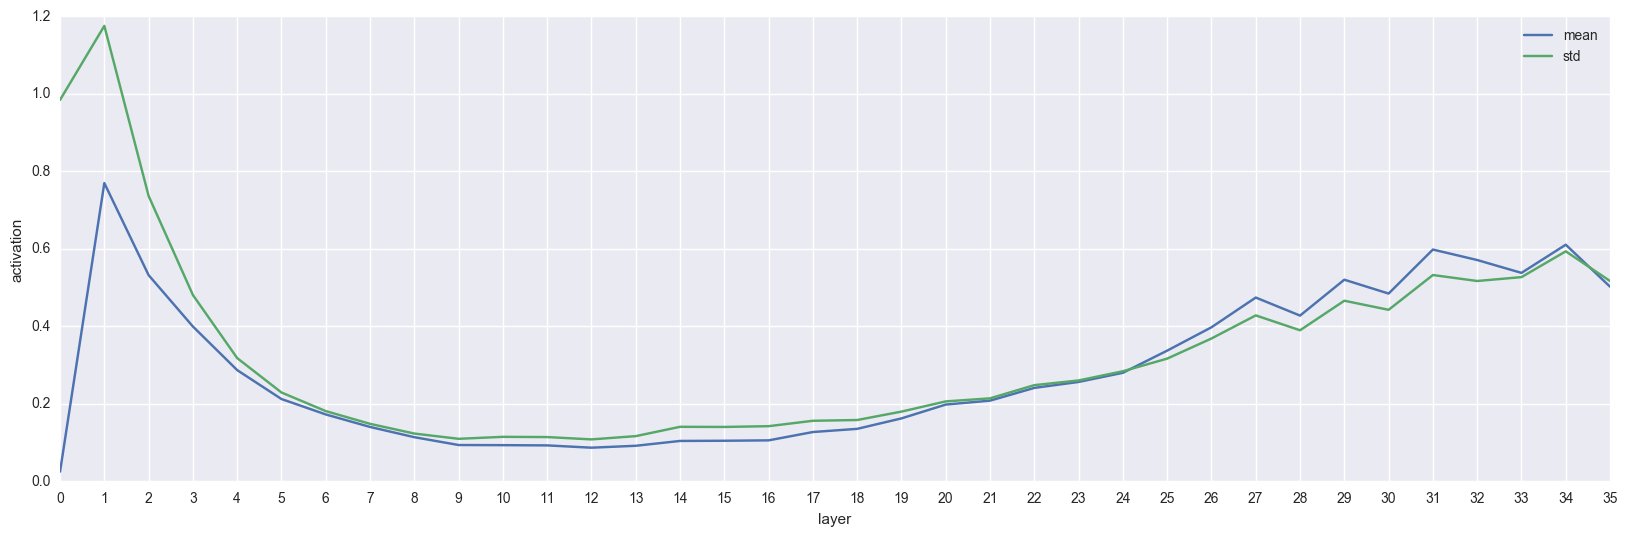

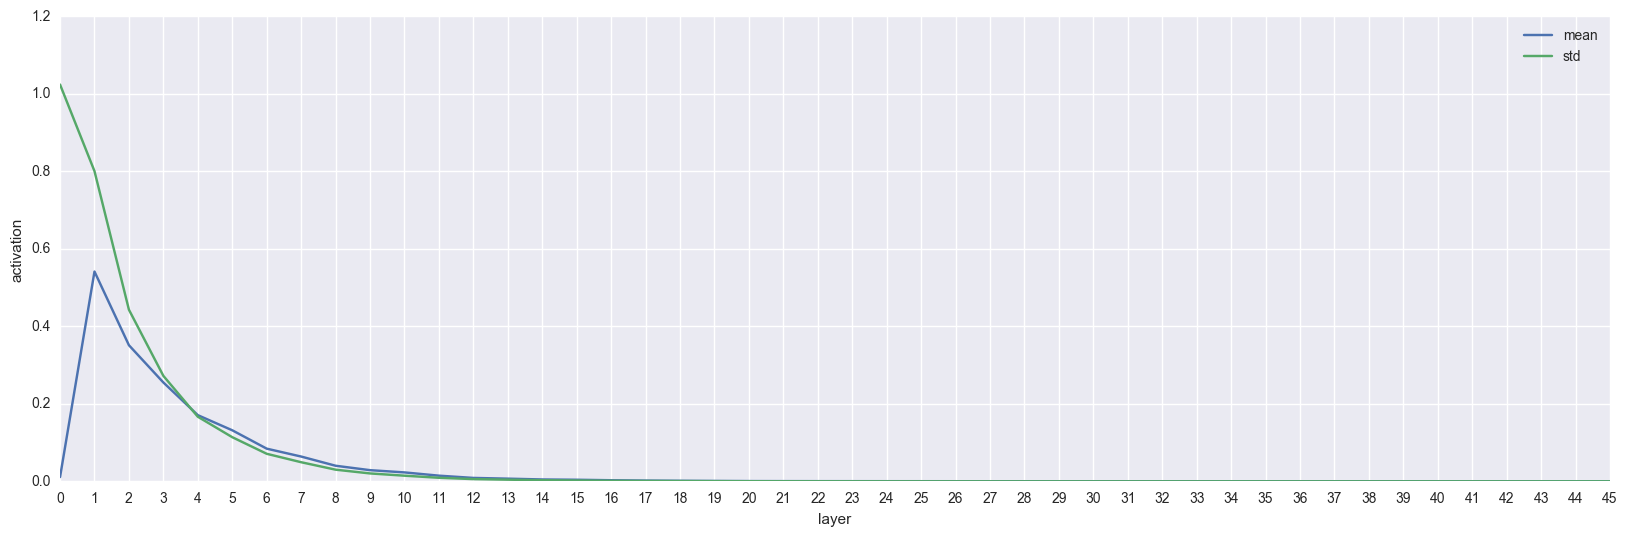

In [64]:
nn.draw_activations()
nn2.draw_activations()
nn3.draw_activations()
nn4.draw_activations()

# Batch Norm

### SGD(1e-2)

In [70]:
%%time
nn = NN_BN(5, 250, SGD(lr=1e-2))
nn.fit(0)

Wall time: 23.1 s


In [71]:
%%time
nn2 = NN_BN(15, 250, SGD(lr=1e-2))
nn2.fit(0)

Wall time: 59.4 s


In [72]:
%%time
nn3 = NN_BN(35, 250, SGD(lr=1e-2))
nn3.fit(0)

Wall time: 2min 29s


In [76]:
%%time
nn4 = NN_BN(45, 250, SGD(lr=1e-2))
nn4.fit(0)

Wall time: 4min 3s


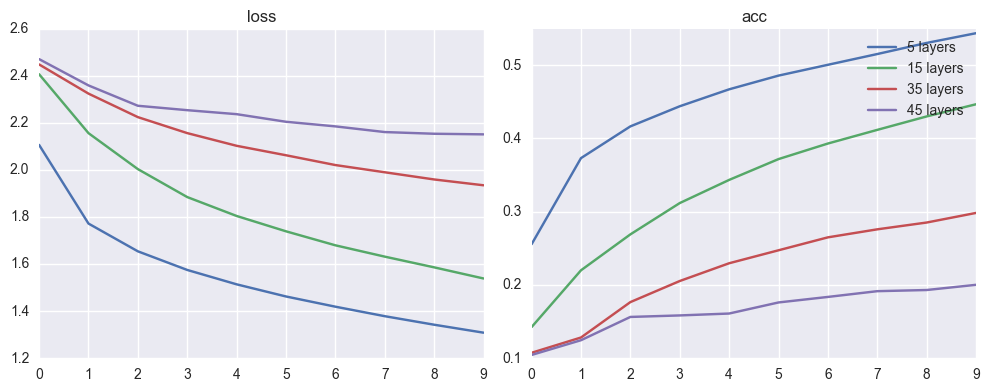

In [77]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(nn.history.history['loss'], label='5 layers')
ax1.plot(nn2.history.history['loss'], label='15 layers')
ax1.plot(nn3.history.history['loss'], label='35 layers')
ax1.plot(nn4.history.history['loss'], label='45 layers')
ax1.set_title('loss')
ax2.plot(nn.history.history['acc'], label='5 layers')
ax2.plot(nn2.history.history['acc'], label='15 layers')
ax2.plot(nn3.history.history['acc'], label='35 layers')
ax2.plot(nn4.history.history['acc'], label='45 layers')
ax2.set_title('acc')
plt.legend()
plt.tight_layout()

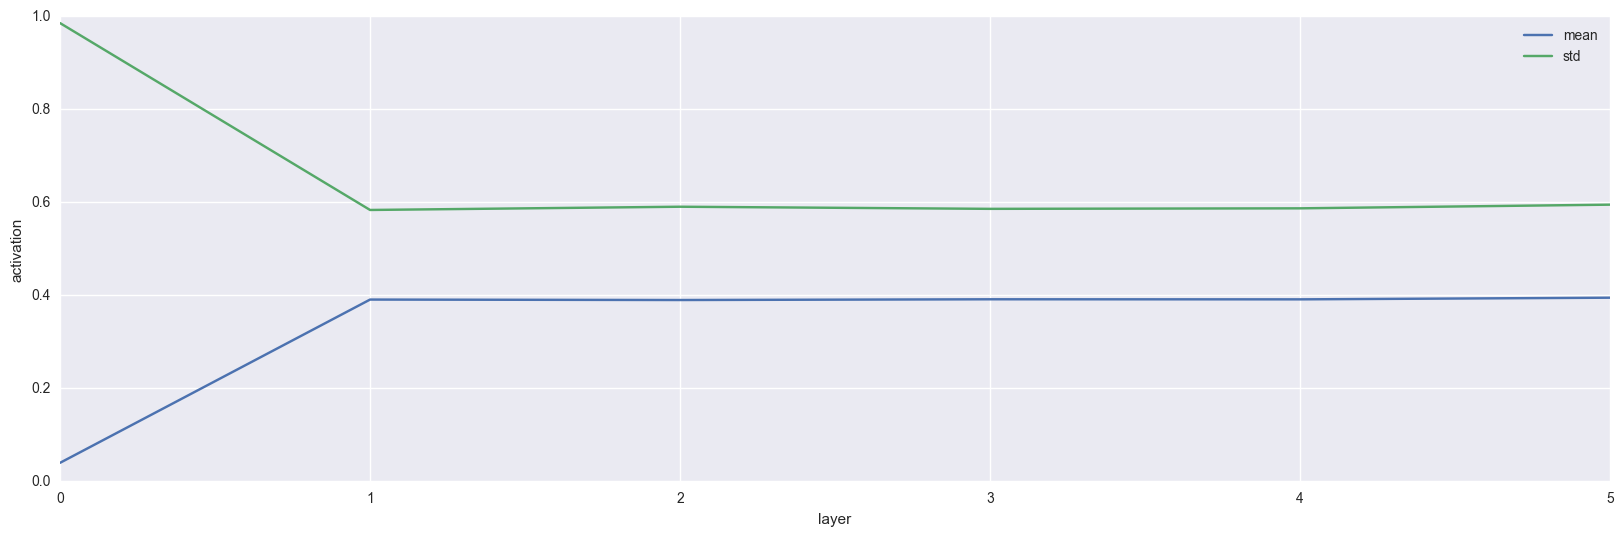

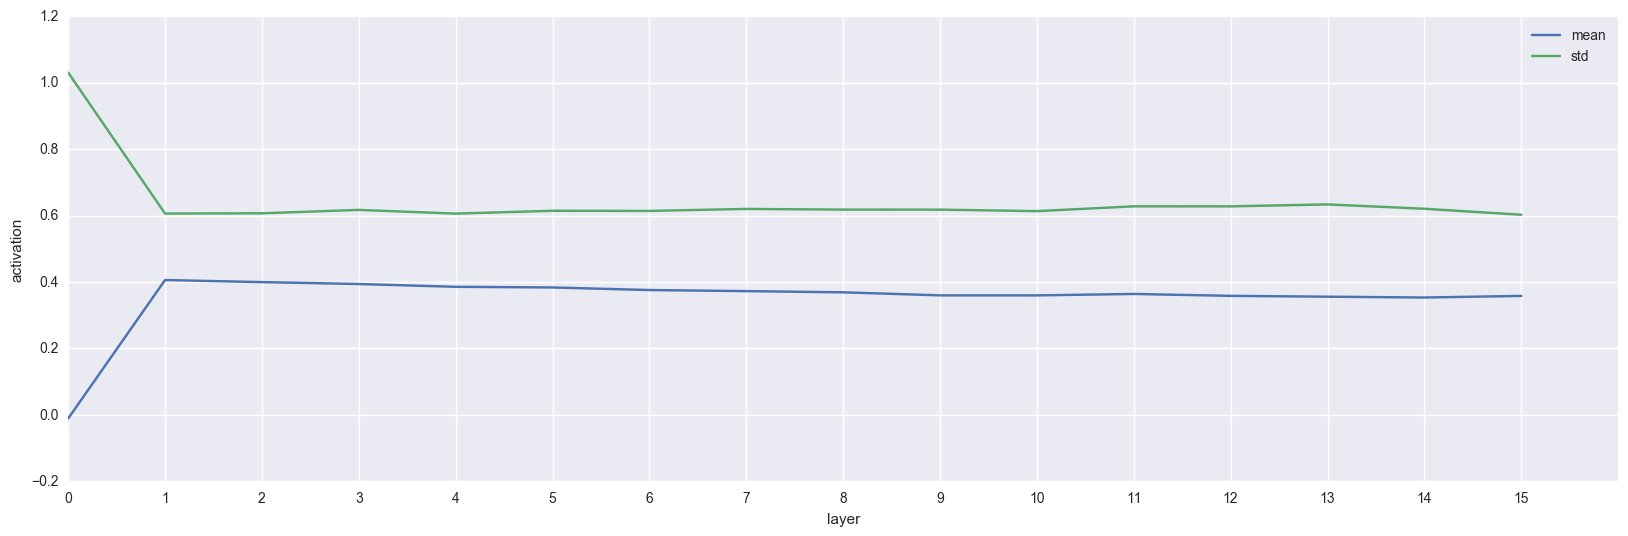

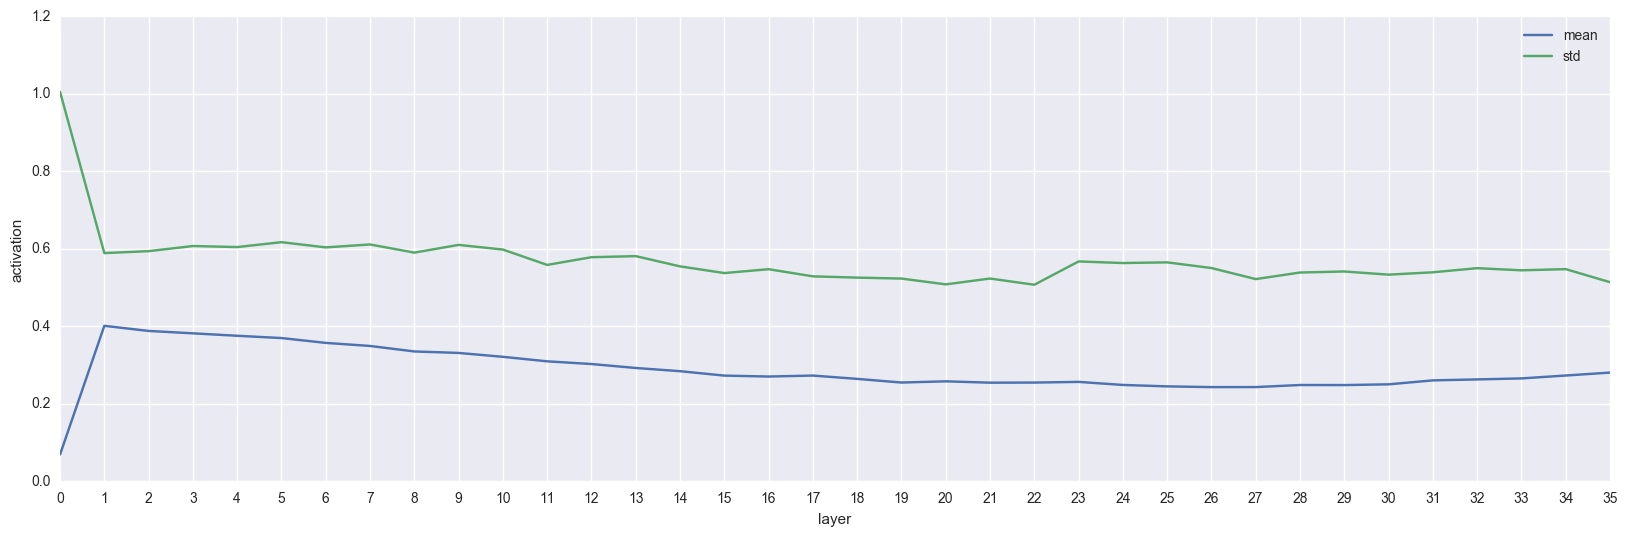

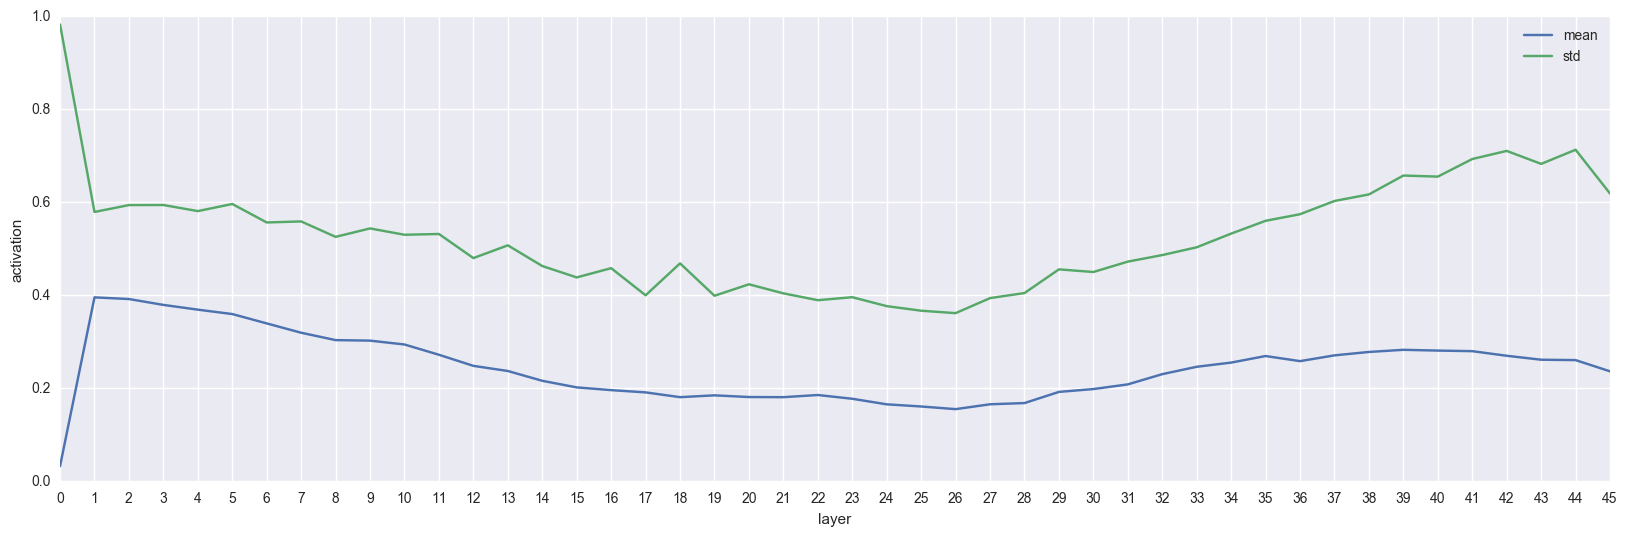

In [78]:
nn.draw_activations()
nn2.draw_activations()
nn3.draw_activations()
nn4.draw_activations()

### SGD(1e-1)

In [85]:
%%time
nn = NN_BN(5, 250, SGD(1e-1))
nn.fit(0)

In [86]:
%%time
nn2 = NN_BN(15, 250, SGD(1e-1))
nn2.fit(0)

In [87]:
%%time
nn3 = NN_BN(35, 250, SGD(1e-1))
nn3.fit(0)

In [88]:
%%time
nn4 = NN_BN(45, 250, SGD(1e-1))
nn4.fit(0)

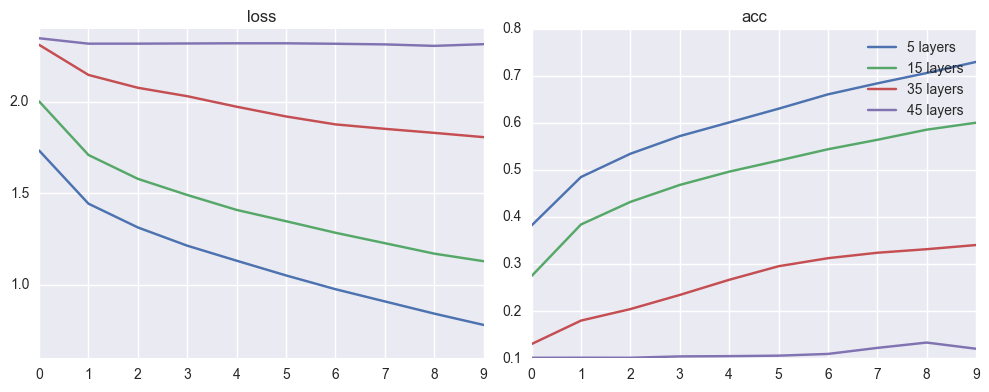

In [89]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(nn.history.history['loss'], label='5 layers')
ax1.plot(nn2.history.history['loss'], label='15 layers')
ax1.plot(nn3.history.history['loss'], label='35 layers')
ax1.plot(nn4.history.history['loss'], label='45 layers')
ax1.set_title('loss')
ax2.plot(nn.history.history['acc'], label='5 layers')
ax2.plot(nn2.history.history['acc'], label='15 layers')
ax2.plot(nn3.history.history['acc'], label='35 layers')
ax2.plot(nn4.history.history['acc'], label='45 layers')
ax2.set_title('acc')
plt.legend()
plt.tight_layout()

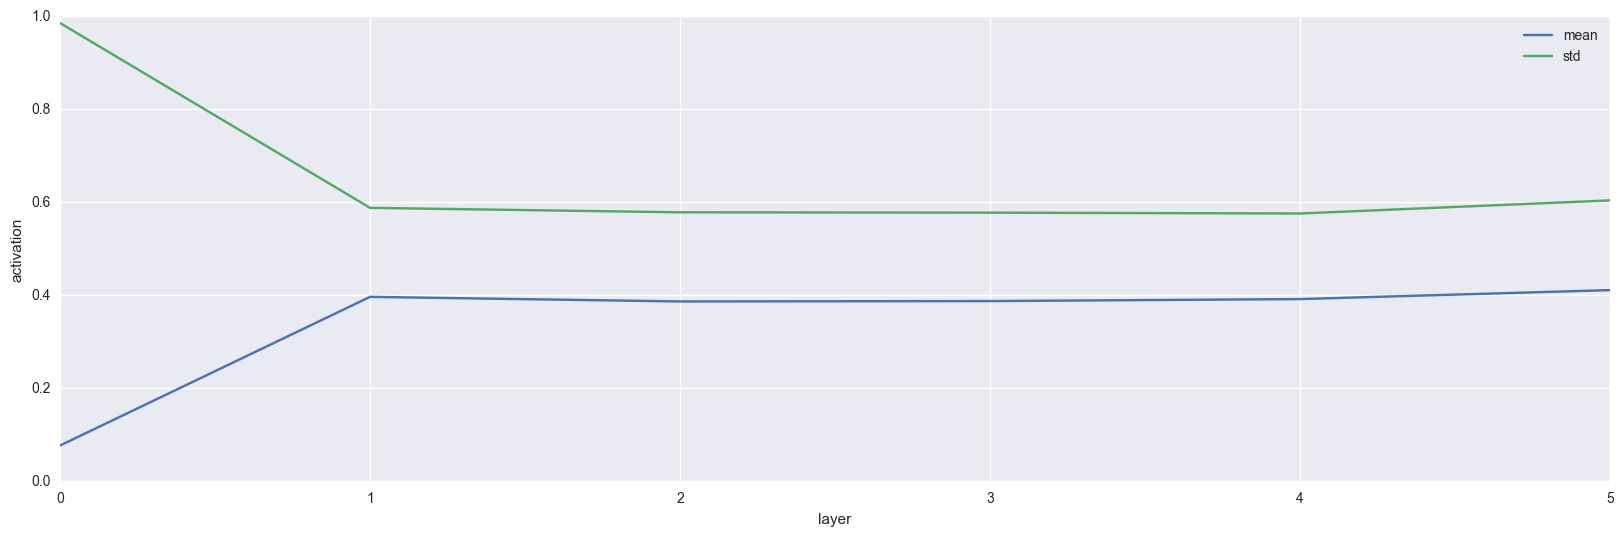

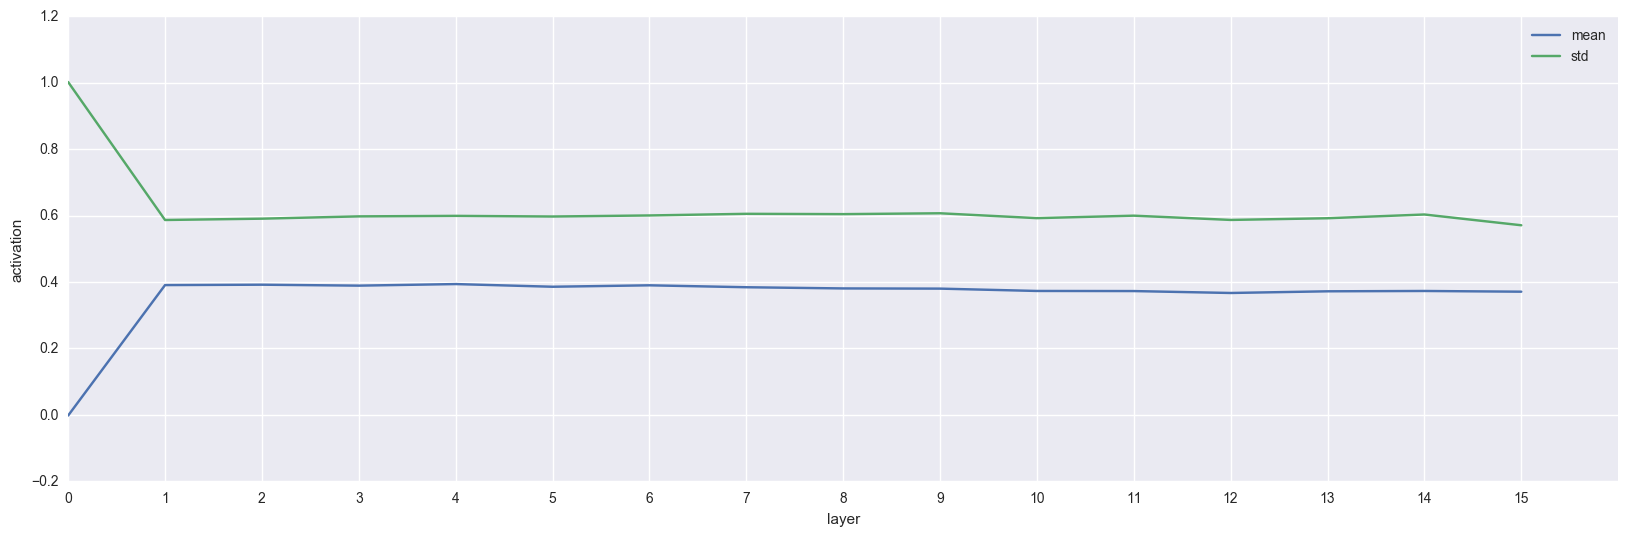

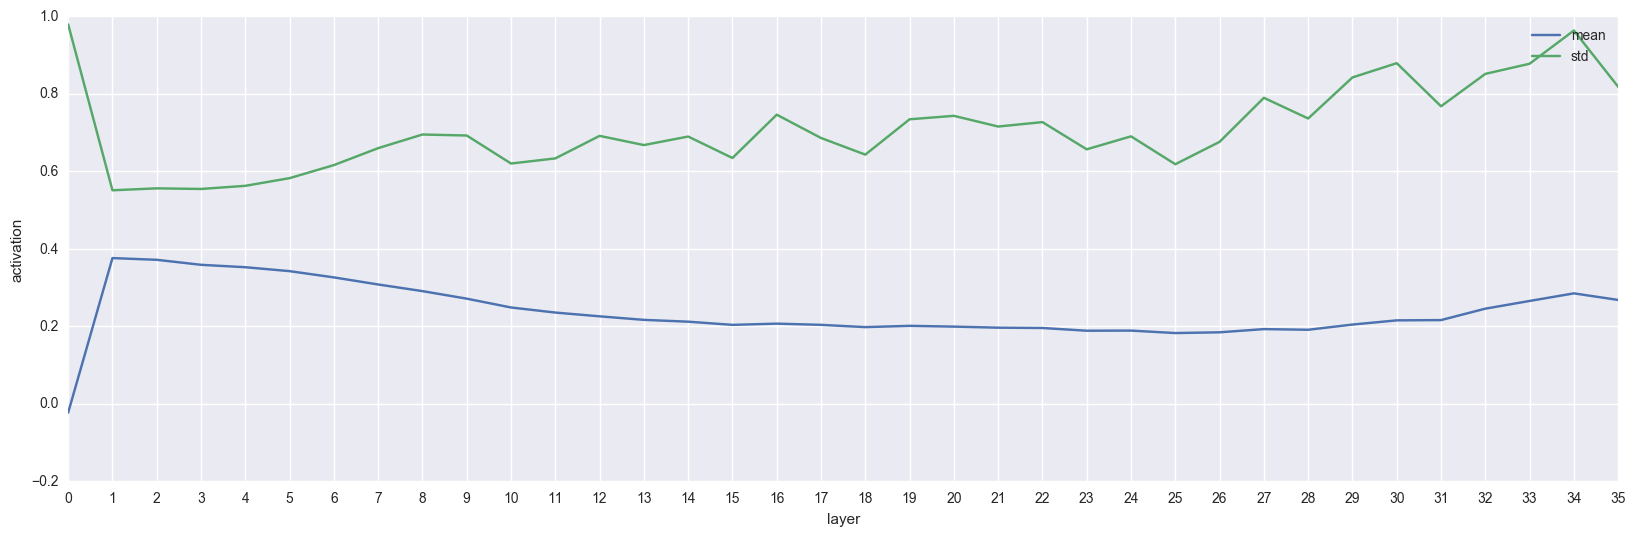

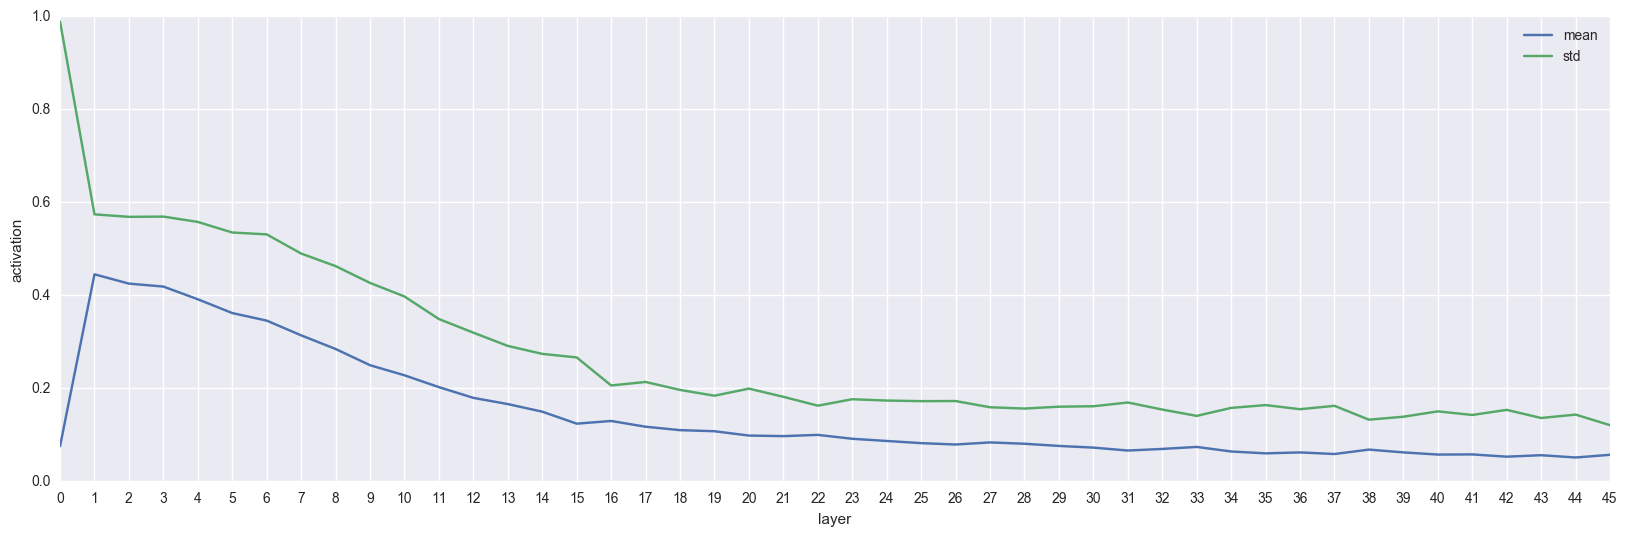

In [90]:
nn.draw_activations()
nn2.draw_activations()
nn3.draw_activations()
nn4.draw_activations()

### Adam(1e-3)

In [91]:
%%time
nn = NN_BN(5, 250, Adam(1e-3))
nn.fit(0)

Wall time: 31.7 s


In [92]:
%%time
nn2 = NN_BN(15, 250, Adam(1e-3))
nn2.fit(0)

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/ASUS/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.5.2-64/tmpyc605fpx/m62d3a9cdf5eb23196b219624a9650394.lib and object C:/Users/ASUS/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.5.2-64/tmpyc605fpx/m62d3a9cdf5eb23196b219624a9650394.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/ASUS/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.5.2-64/tmpncsl5ba8/ma07de5d2731a1c2a1353d803a8809b43.lib and object C:/Users/ASUS/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.5.2-64/tmpncsl5ba8/ma07de5d2731a1c2a1353d803a8809b43.exp



Wall time: 1min 32s


In [93]:
%%time
nn3 = NN_BN(35, 250, Adam(1e-3))
nn3.fit(0)

Wall time: 4min 3s


In [94]:
%%time
nn4 = NN_BN(45, 250, Adam(1e-3))
nn4.fit(0)

Wall time: 5min 53s


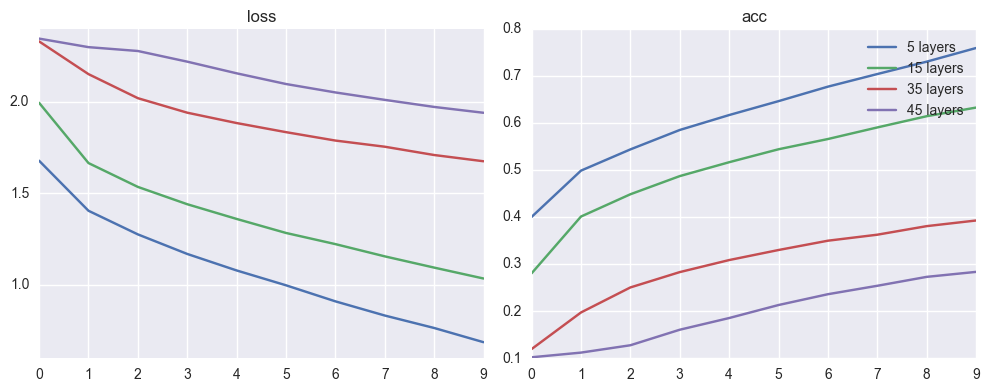

In [95]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(nn.history.history['loss'], label='5 layers')
ax1.plot(nn2.history.history['loss'], label='15 layers')
ax1.plot(nn3.history.history['loss'], label='35 layers')
ax1.plot(nn4.history.history['loss'], label='45 layers')
ax1.set_title('loss')
ax2.plot(nn.history.history['acc'], label='5 layers')
ax2.plot(nn2.history.history['acc'], label='15 layers')
ax2.plot(nn3.history.history['acc'], label='35 layers')
ax2.plot(nn4.history.history['acc'], label='45 layers')
ax2.set_title('acc')
plt.legend()
plt.tight_layout()

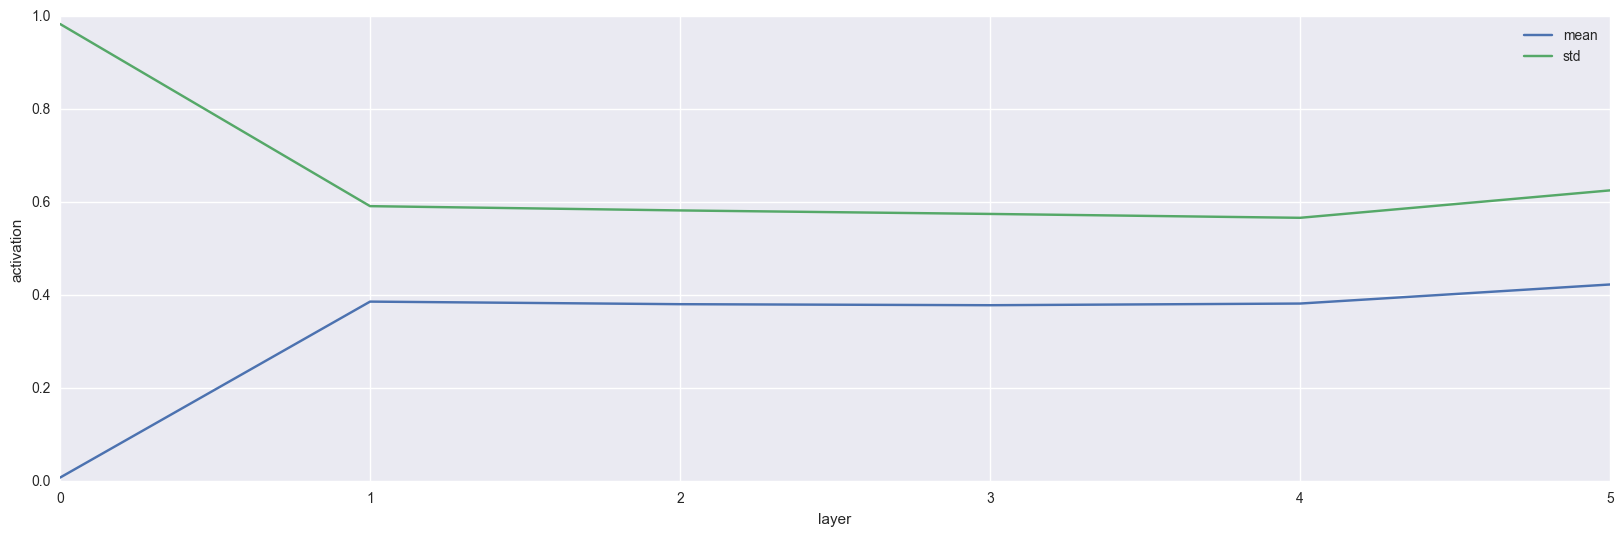

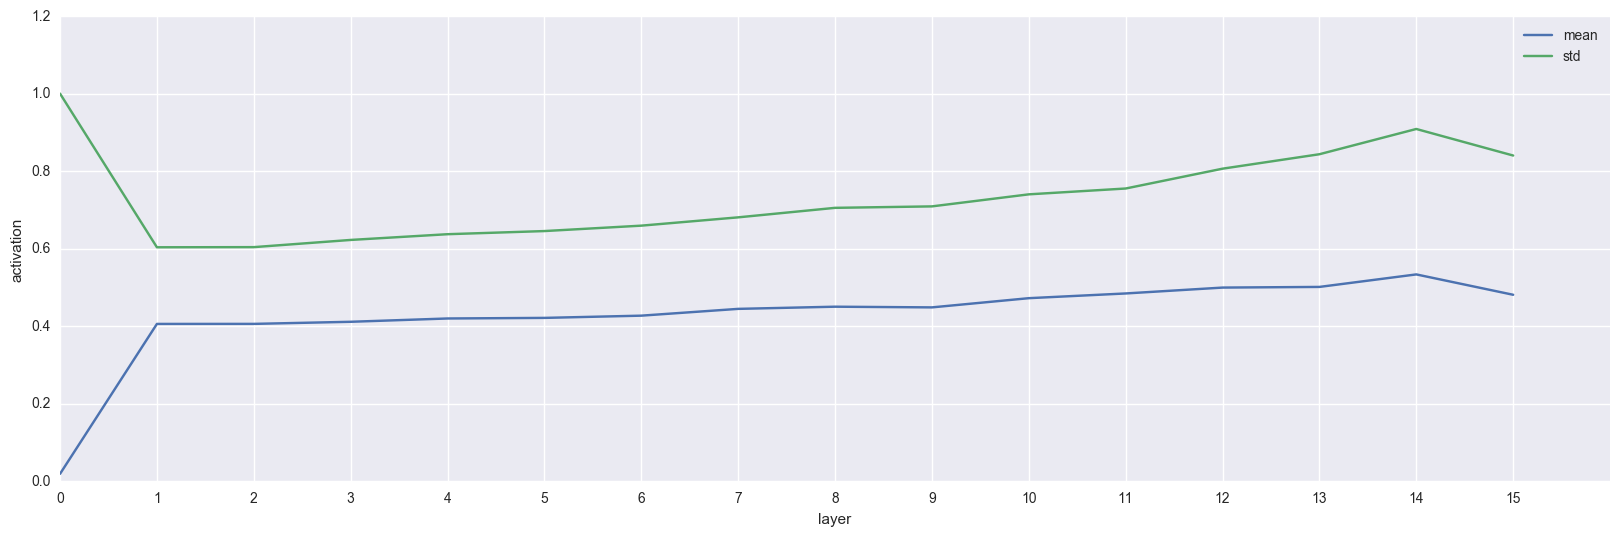

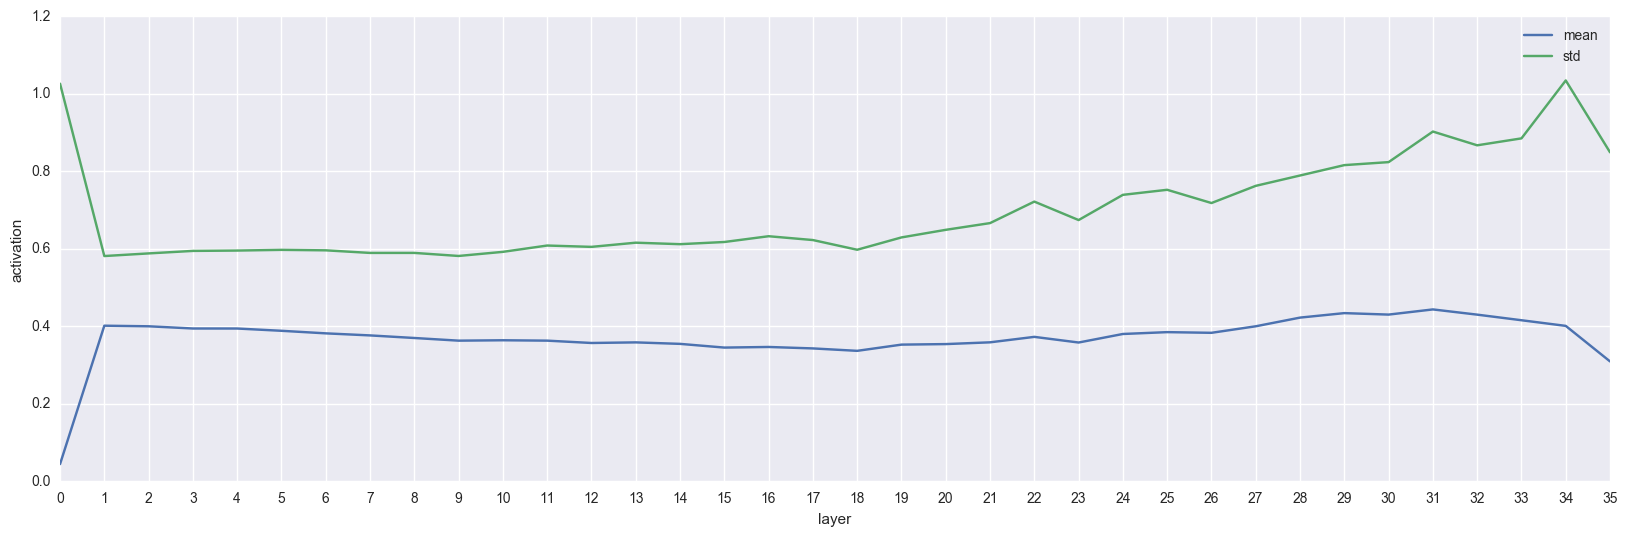

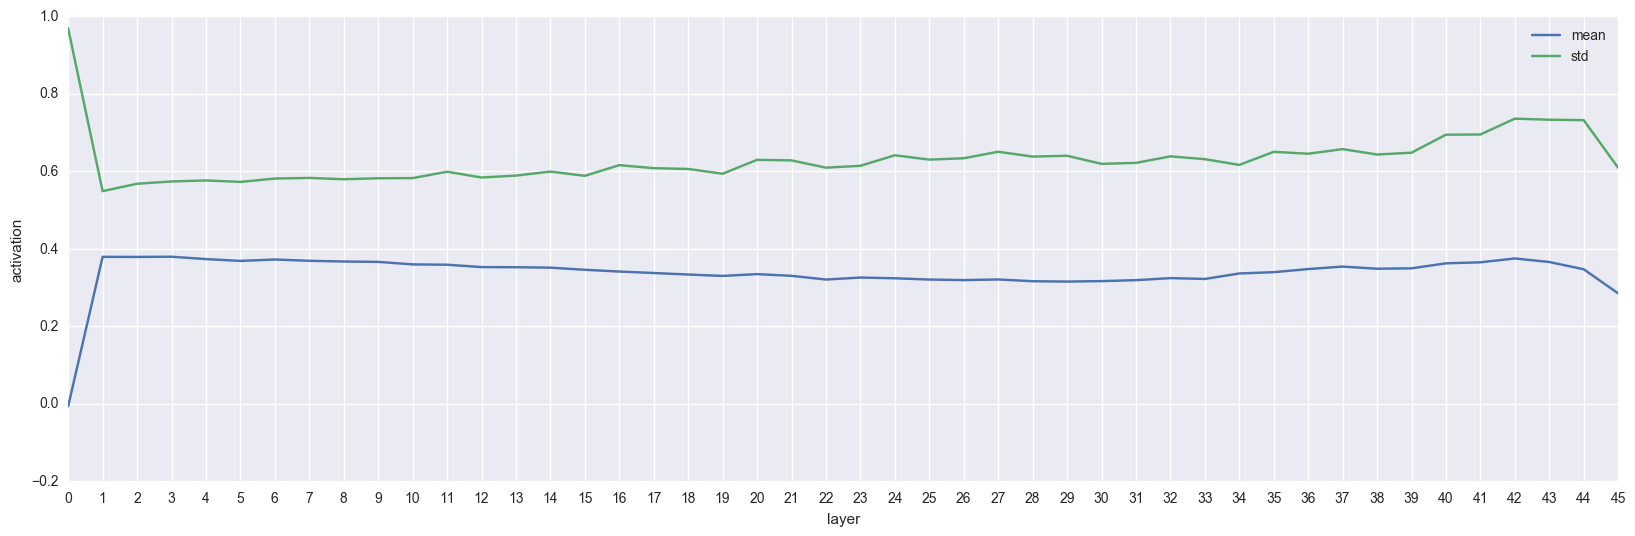

In [96]:
nn.draw_activations()
nn2.draw_activations()
nn3.draw_activations()
nn4.draw_activations()

# Norm Prop

### SGD(1e-2)

In [15]:
%%time
nn = NN_NP(5, 250, SGD(1e-2))
nn.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1s - loss: 1.9851 - acc: 0.2903 - val_loss: 1.8075 - val_acc: 0.3552
Epoch 2/10
50000/50000 [==============================] - 1s - loss: 1.7134 - acc: 0.3921 - val_loss: 1.6939 - val_acc: 0.3940
Epoch 3/10
50000/50000 [==============================] - 1s - loss: 1.6030 - acc: 0.4316 - val_loss: 1.6337 - val_acc: 0.4180
Epoch 4/10
50000/50000 [==============================] - 1s - loss: 1.5268 - acc: 0.4614 - val_loss: 1.5923 - val_acc: 0.4341
Epoch 5/10
50000/50000 [==============================] - 1s - loss: 1.4658 - acc: 0.4846 - val_loss: 1.5646 - val_acc: 0.4426
Epoch 6/10
50000/50000 [==============================] - 1s - loss: 1.4148 - acc: 0.5030 - val_loss: 1.5397 - val_acc: 0.4480
Epoch 7/10
50000/50000 [==============================] - 1s - loss: 1.3694 - acc: 0.5200 - val_loss: 1.5189 - val_acc: 0.4570
Epoch 8/10
50000/50000 [==============================] - 1s 

In [16]:
%%time
nn2 = NN_NP(15, 250, SGD(1e-2))
nn2.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2s - loss: 2.0631 - acc: 0.2463 - val_loss: 1.9006 - val_acc: 0.3182
Epoch 2/10
50000/50000 [==============================] - 2s - loss: 1.7980 - acc: 0.3495 - val_loss: 1.7538 - val_acc: 0.3626
Epoch 3/10
50000/50000 [==============================] - 2s - loss: 1.6748 - acc: 0.3956 - val_loss: 1.6924 - val_acc: 0.3940
Epoch 4/10
50000/50000 [==============================] - 2s - loss: 1.5876 - acc: 0.4296 - val_loss: 1.6736 - val_acc: 0.4031
Epoch 5/10
50000/50000 [==============================] - 2s - loss: 1.5153 - acc: 0.4582 - val_loss: 1.6328 - val_acc: 0.4182
Epoch 6/10
50000/50000 [==============================] - 2s - loss: 1.4573 - acc: 0.4794 - val_loss: 1.6094 - val_acc: 0.4286
Epoch 7/10
50000/50000 [==============================] - 2s - loss: 1.3998 - acc: 0.5000 - val_loss: 1.6009 - val_acc: 0.4359
Epoch 8/10
50000/50000 [==============================] - 2s 

In [17]:
%%time
nn3 = NN_NP(35, 250, SGD(1e-2))
nn3.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s - loss: 2.2242 - acc: 0.1623 - val_loss: 2.1450 - val_acc: 0.1921
Epoch 2/10
50000/50000 [==============================] - 3s - loss: 1.9920 - acc: 0.2510 - val_loss: 1.9034 - val_acc: 0.2741
Epoch 3/10
50000/50000 [==============================] - 3s - loss: 1.8765 - acc: 0.2998 - val_loss: 1.8560 - val_acc: 0.3013
Epoch 4/10
50000/50000 [==============================] - 3s - loss: 1.7992 - acc: 0.3350 - val_loss: 1.7970 - val_acc: 0.3283
Epoch 5/10
50000/50000 [==============================] - 3s - loss: 1.7306 - acc: 0.3643 - val_loss: 1.7373 - val_acc: 0.3656
Epoch 6/10
50000/50000 [==============================] - 3s - loss: 1.6746 - acc: 0.3933 - val_loss: 1.7945 - val_acc: 0.3487
Epoch 7/10
50000/50000 [==============================] - 3s - loss: 1.6185 - acc: 0.4187 - val_loss: 1.6623 - val_acc: 0.4070
Epoch 8/10
50000/50000 [==============================] - 3s 

In [18]:
%%time
nn4 = NN_NP(45, 250, SGD(1e-2))
nn4.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s - loss: 2.2269 - acc: 0.1534 - val_loss: 2.0789 - val_acc: 0.2127
Epoch 2/10
50000/50000 [==============================] - 3s - loss: 2.0343 - acc: 0.2245 - val_loss: 1.9495 - val_acc: 0.2565
Epoch 3/10
50000/50000 [==============================] - 3s - loss: 1.9231 - acc: 0.2739 - val_loss: 1.9162 - val_acc: 0.2922
Epoch 4/10
50000/50000 [==============================] - 3s - loss: 1.8499 - acc: 0.3061 - val_loss: 1.8370 - val_acc: 0.3057
Epoch 5/10
50000/50000 [==============================] - 3s - loss: 1.7816 - acc: 0.3375 - val_loss: 1.8017 - val_acc: 0.3358
Epoch 6/10
50000/50000 [==============================] - 3s - loss: 1.7346 - acc: 0.3633 - val_loss: 1.8448 - val_acc: 0.3188
Epoch 7/10
50000/50000 [==============================] - 3s - loss: 1.6913 - acc: 0.3843 - val_loss: 1.7752 - val_acc: 0.3688
Epoch 8/10
50000/50000 [==============================] - 3s 

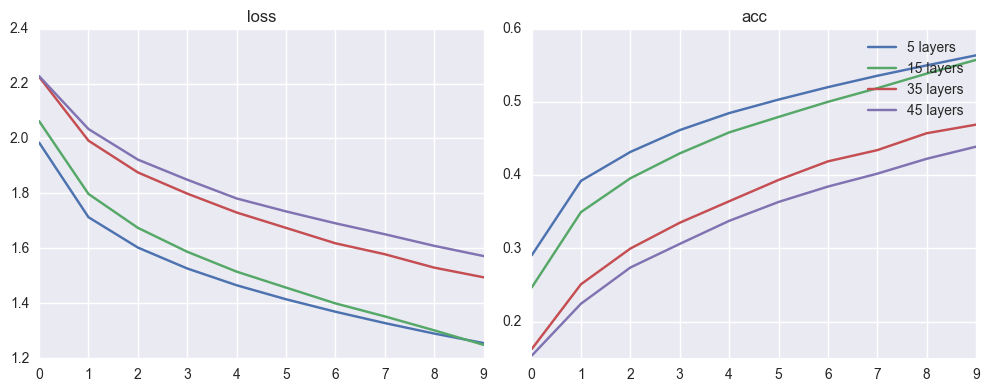

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(nn.history.history['loss'], label='5 layers')
ax1.plot(nn2.history.history['loss'], label='15 layers')
ax1.plot(nn3.history.history['loss'], label='35 layers')
ax1.plot(nn4.history.history['loss'], label='45 layers')
ax1.set_title('loss')
ax2.plot(nn.history.history['acc'], label='5 layers')
ax2.plot(nn2.history.history['acc'], label='15 layers')
ax2.plot(nn3.history.history['acc'], label='35 layers')
ax2.plot(nn4.history.history['acc'], label='45 layers')
ax2.set_title('acc')
plt.legend()
plt.tight_layout()

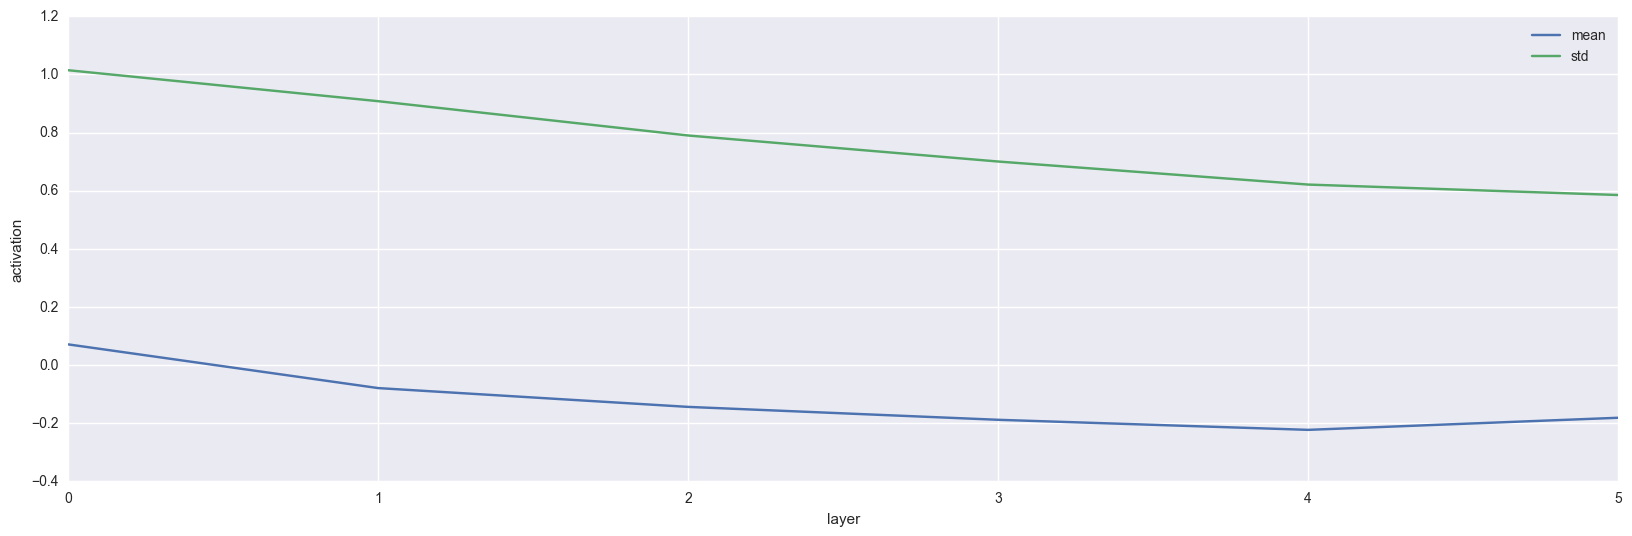

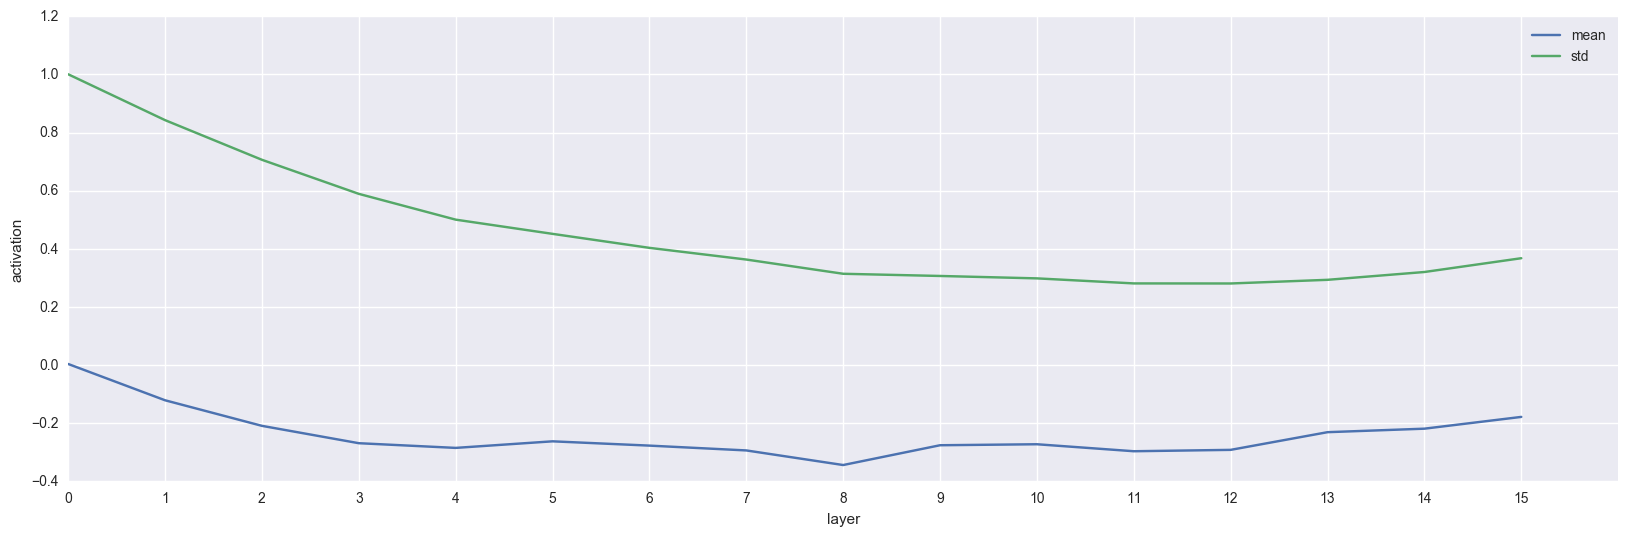

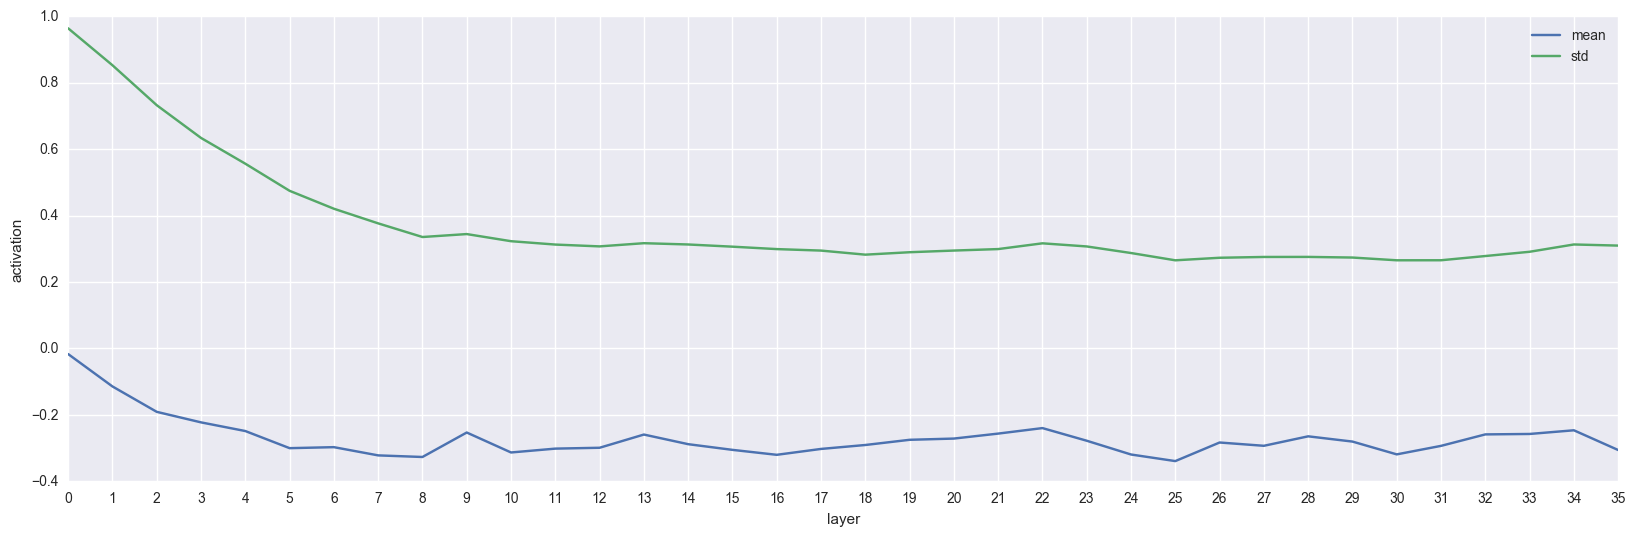

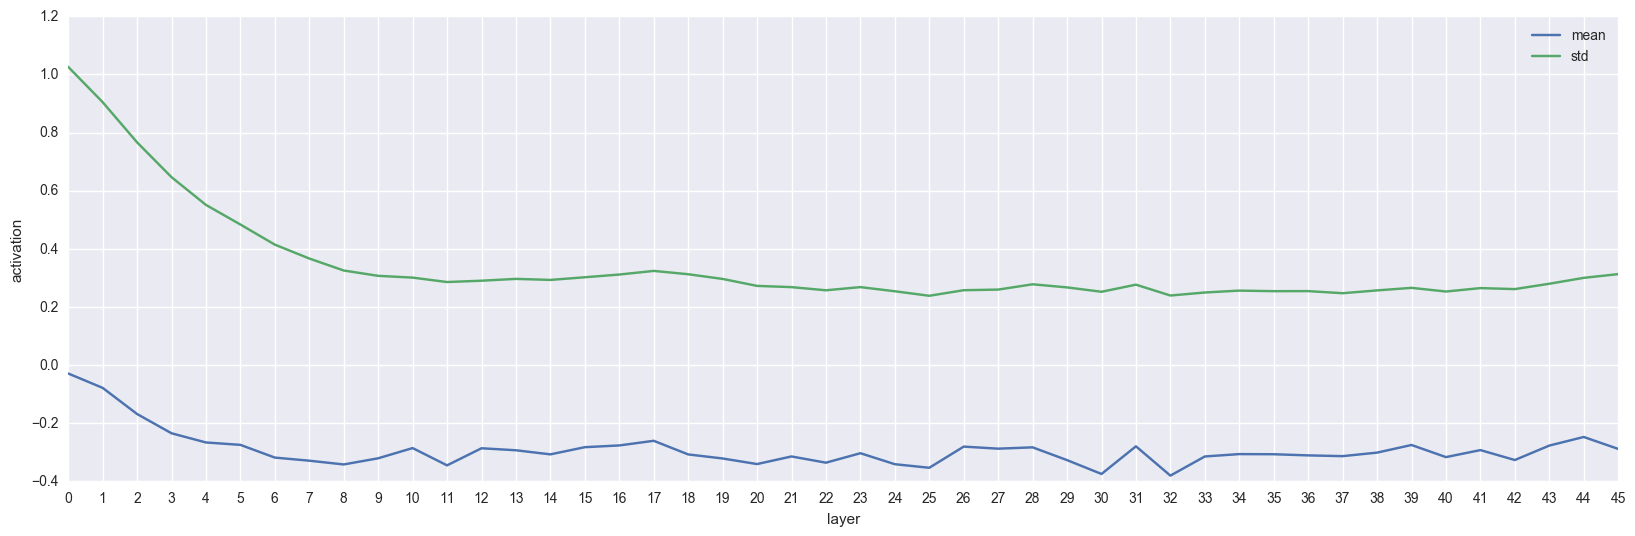

In [20]:
nn.draw_activations()
nn2.draw_activations()
nn3.draw_activations()
nn4.draw_activations()

### SGD(1e-3)

In [21]:
%%time
nn = NN_NP(5, 250, SGD(1e-3))
nn.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1s - loss: 2.3721 - acc: 0.1528 - val_loss: 2.2212 - val_acc: 0.2010
Epoch 2/10
50000/50000 [==============================] - 1s - loss: 2.1616 - acc: 0.2249 - val_loss: 2.1006 - val_acc: 0.2475
Epoch 3/10
50000/50000 [==============================] - 1s - loss: 2.0633 - acc: 0.2631 - val_loss: 2.0264 - val_acc: 0.2781
Epoch 4/10
50000/50000 [==============================] - 1s - loss: 1.9950 - acc: 0.2894 - val_loss: 1.9727 - val_acc: 0.2984
Epoch 5/10
50000/50000 [==============================] - 1s - loss: 1.9419 - acc: 0.3082 - val_loss: 1.9310 - val_acc: 0.3134
Epoch 6/10
50000/50000 [==============================] - 1s - loss: 1.8986 - acc: 0.3243 - val_loss: 1.8968 - val_acc: 0.3242
Epoch 7/10
50000/50000 [==============================] - 1s - loss: 1.8623 - acc: 0.3372 - val_loss: 1.8687 - val_acc: 0.3363
Epoch 8/10
50000/50000 [==============================] - 1s 

In [22]:
%%time
nn2 = NN_NP(15, 250, SGD(1e-3))
nn2.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2s - loss: 2.2974 - acc: 0.1325 - val_loss: 2.2407 - val_acc: 0.1714
Epoch 2/10
50000/50000 [==============================] - 2s - loss: 2.1971 - acc: 0.2011 - val_loss: 2.1670 - val_acc: 0.2198
Epoch 3/10
50000/50000 [==============================] - 2s - loss: 2.1219 - acc: 0.2407 - val_loss: 2.1005 - val_acc: 0.2492
Epoch 4/10
50000/50000 [==============================] - 2s - loss: 2.0543 - acc: 0.2677 - val_loss: 2.0424 - val_acc: 0.2663
Epoch 5/10
50000/50000 [==============================] - 2s - loss: 1.9969 - acc: 0.2891 - val_loss: 1.9953 - val_acc: 0.2829
Epoch 6/10
50000/50000 [==============================] - 2s - loss: 1.9491 - acc: 0.3053 - val_loss: 1.9571 - val_acc: 0.2902
Epoch 7/10
50000/50000 [==============================] - 2s - loss: 1.9086 - acc: 0.3180 - val_loss: 1.9261 - val_acc: 0.2996
Epoch 8/10
50000/50000 [==============================] - 2s 

In [23]:
%%time
nn3 = NN_NP(35, 250, SGD(1e-3))
nn3.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s - loss: 2.3273 - acc: 0.1309 - val_loss: 2.2623 - val_acc: 0.1577
Epoch 2/10
50000/50000 [==============================] - 3s - loss: 2.2231 - acc: 0.1770 - val_loss: 2.1812 - val_acc: 0.1898
Epoch 3/10
50000/50000 [==============================] - 3s - loss: 2.1379 - acc: 0.2072 - val_loss: 2.1070 - val_acc: 0.2104
Epoch 4/10
50000/50000 [==============================] - 3s - loss: 2.0708 - acc: 0.2305 - val_loss: 2.0583 - val_acc: 0.2406
Epoch 5/10
50000/50000 [==============================] - 3s - loss: 2.0180 - acc: 0.2555 - val_loss: 2.0195 - val_acc: 0.2523
Epoch 6/10
50000/50000 [==============================] - 3s - loss: 1.9752 - acc: 0.2713 - val_loss: 1.9922 - val_acc: 0.2614
Epoch 7/10
50000/50000 [==============================] - 3s - loss: 1.9384 - acc: 0.2851 - val_loss: 1.9917 - val_acc: 0.2612
Epoch 8/10
50000/50000 [==============================] - 3s 

In [24]:
%%time
nn4 = NN_NP(45, 250, SGD(1e-3))
nn4.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s - loss: 2.2866 - acc: 0.1241 - val_loss: 2.2551 - val_acc: 0.1494
Epoch 2/10
50000/50000 [==============================] - 4s - loss: 2.2104 - acc: 0.1701 - val_loss: 2.1813 - val_acc: 0.1821
Epoch 3/10
50000/50000 [==============================] - 3s - loss: 2.1430 - acc: 0.1934 - val_loss: 2.1314 - val_acc: 0.1978
Epoch 4/10
50000/50000 [==============================] - 3s - loss: 2.0939 - acc: 0.2116 - val_loss: 2.0920 - val_acc: 0.2132
Epoch 5/10
50000/50000 [==============================] - 4s - loss: 2.0548 - acc: 0.2325 - val_loss: 2.0700 - val_acc: 0.2167
Epoch 6/10
50000/50000 [==============================] - 4s - loss: 2.0212 - acc: 0.2488 - val_loss: 2.0511 - val_acc: 0.2352
Epoch 7/10
50000/50000 [==============================] - 4s - loss: 1.9898 - acc: 0.2652 - val_loss: 2.0386 - val_acc: 0.2426
Epoch 8/10
50000/50000 [==============================] - 4s 

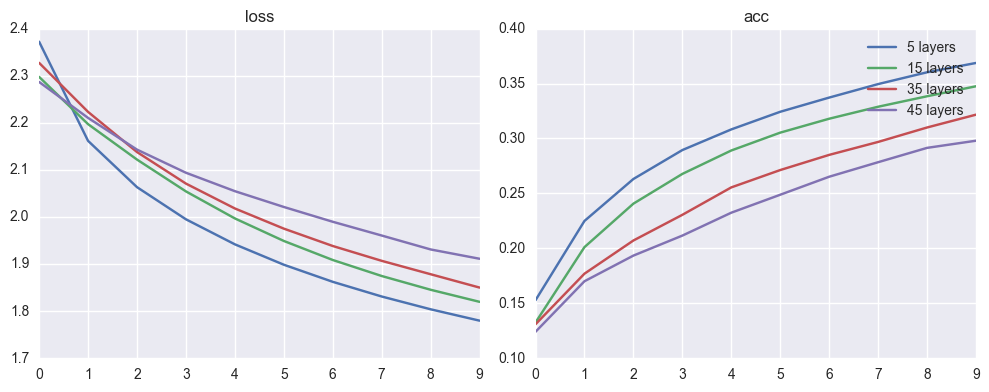

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(nn.history.history['loss'], label='5 layers')
ax1.plot(nn2.history.history['loss'], label='15 layers')
ax1.plot(nn3.history.history['loss'], label='35 layers')
ax1.plot(nn4.history.history['loss'], label='45 layers')
ax1.set_title('loss')
ax2.plot(nn.history.history['acc'], label='5 layers')
ax2.plot(nn2.history.history['acc'], label='15 layers')
ax2.plot(nn3.history.history['acc'], label='35 layers')
ax2.plot(nn4.history.history['acc'], label='45 layers')
ax2.set_title('acc')
plt.legend()
plt.tight_layout()

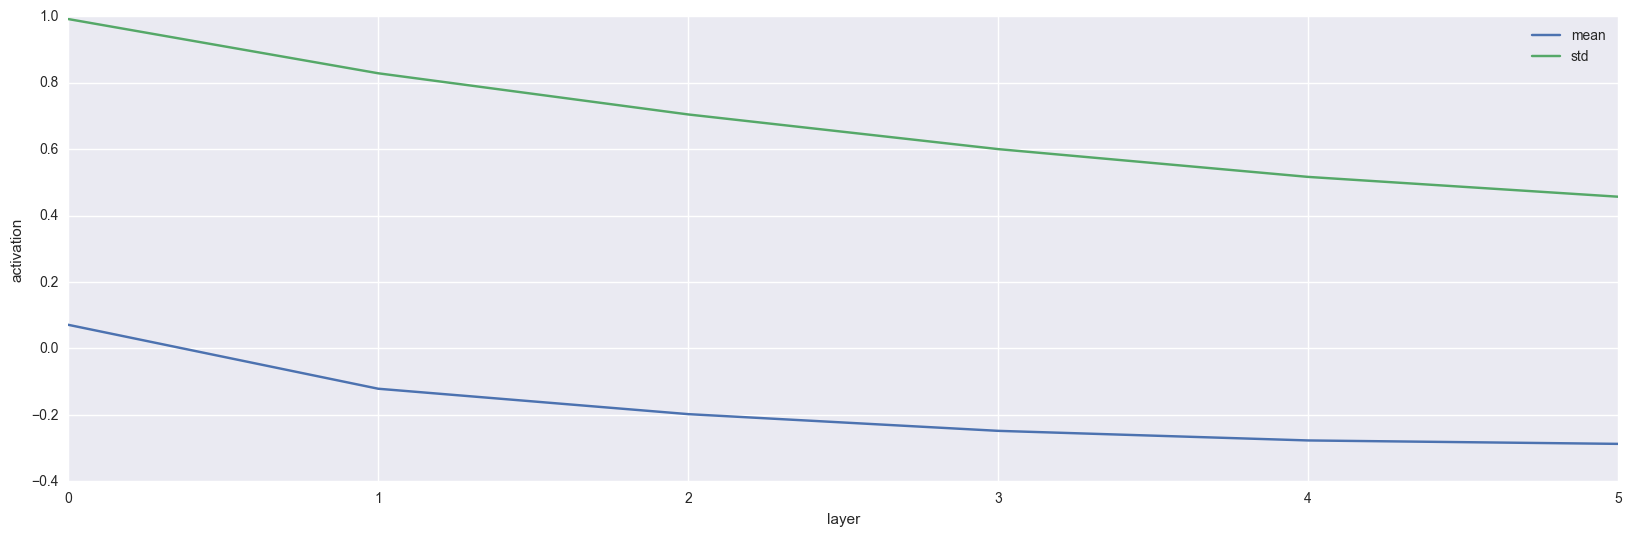

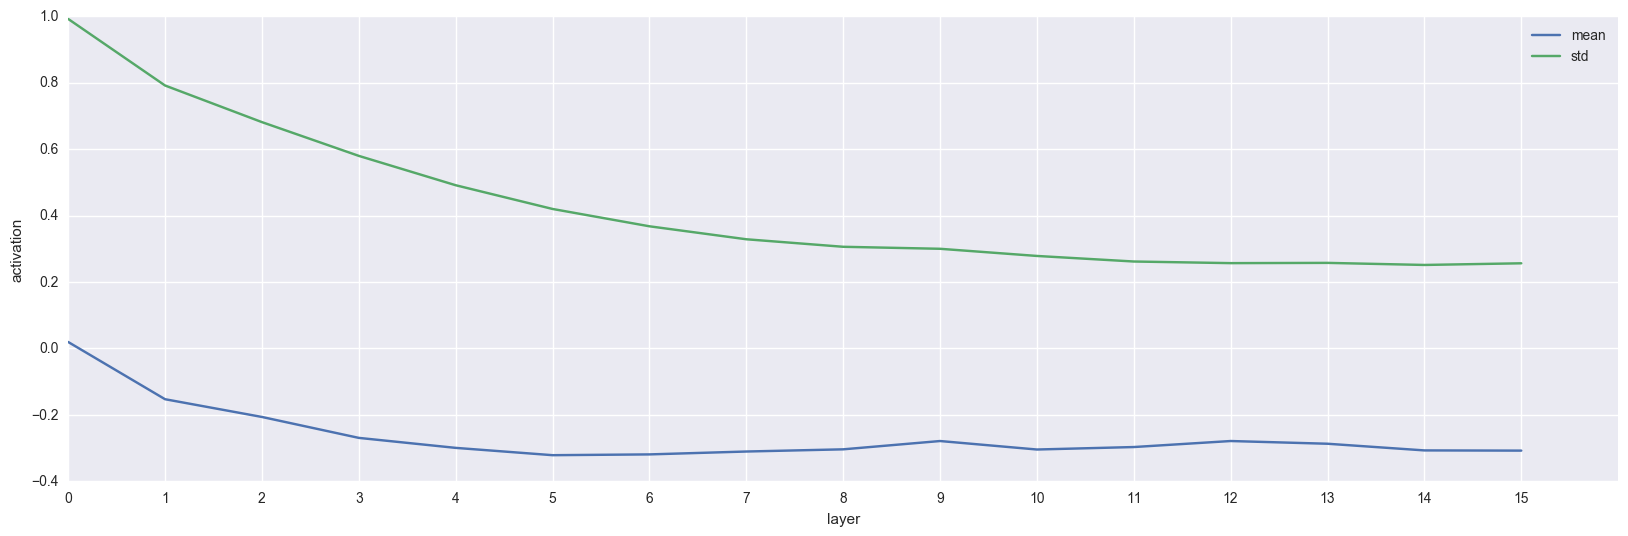

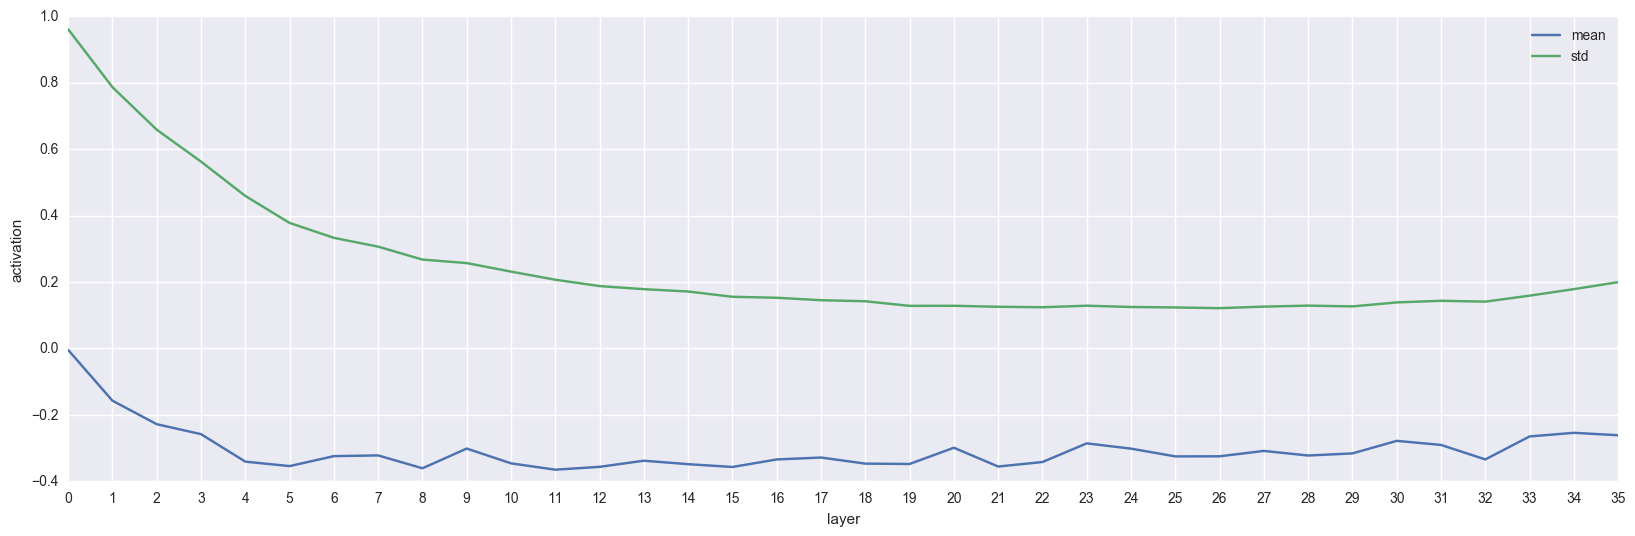

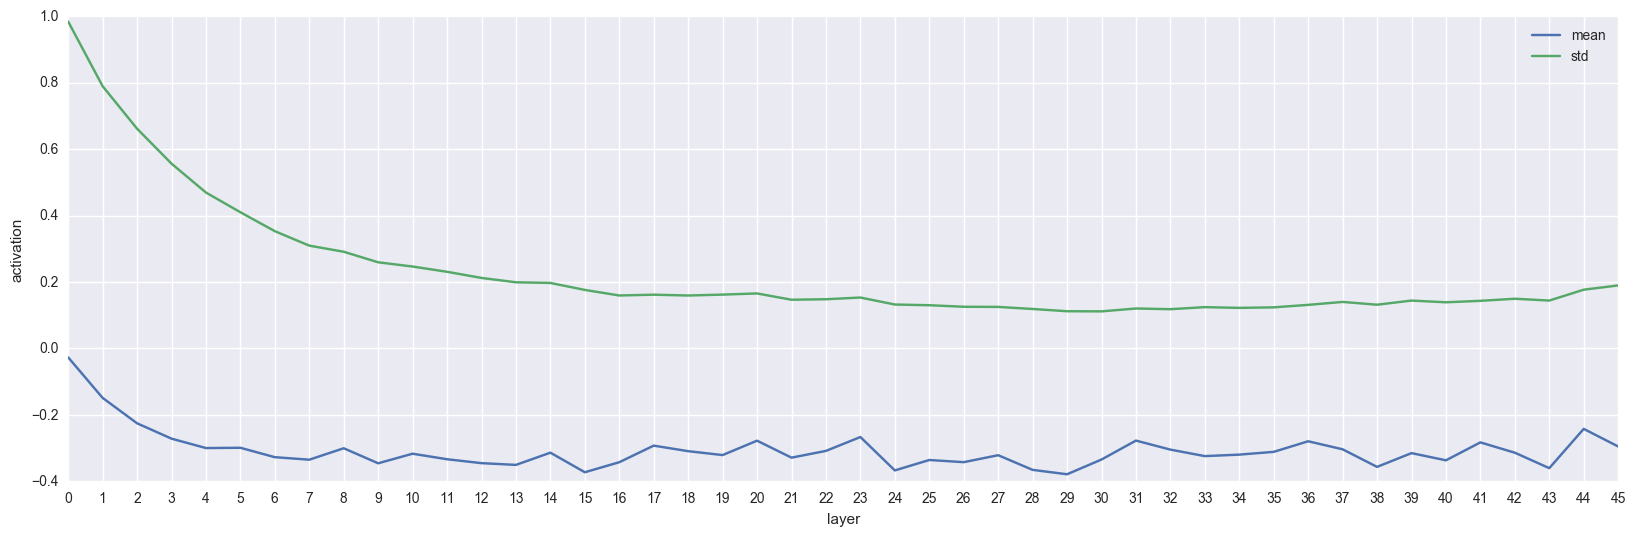

In [26]:
nn.draw_activations()
nn2.draw_activations()
nn3.draw_activations()
nn4.draw_activations()

### SGD (1e-1)

In [27]:
%%time
nn = NN_NP(5, 250, SGD(1e-1))
nn.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1s - loss: 1.7648 - acc: 0.3700 - val_loss: 1.6888 - val_acc: 0.3951
Epoch 2/10
50000/50000 [==============================] - 1s - loss: 1.4810 - acc: 0.4721 - val_loss: 1.4978 - val_acc: 0.4669
Epoch 3/10
50000/50000 [==============================] - 1s - loss: 1.3387 - acc: 0.5246 - val_loss: 1.4673 - val_acc: 0.4833
Epoch 4/10
50000/50000 [==============================] - 1s - loss: 1.2352 - acc: 0.5623 - val_loss: 1.4515 - val_acc: 0.4963
Epoch 5/10
50000/50000 [==============================] - 1s - loss: 1.1375 - acc: 0.6001 - val_loss: 1.4496 - val_acc: 0.4992
Epoch 6/10
50000/50000 [==============================] - 1s - loss: 1.0657 - acc: 0.6258 - val_loss: 1.4742 - val_acc: 0.4928
Epoch 7/10
50000/50000 [==============================] - 1s - loss: 0.9786 - acc: 0.6586 - val_loss: 1.4803 - val_acc: 0.5038
Epoch 8/10
50000/50000 [==============================] - 1s 

In [28]:
%%time
nn2 = NN_NP(15, 250, SGD(1e-1))
nn2.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2s - loss: 2.2654 - acc: 0.2568 - val_loss: 1.9030 - val_acc: 0.3160
Epoch 2/10
50000/50000 [==============================] - 2s - loss: 1.7510 - acc: 0.3682 - val_loss: 1.7562 - val_acc: 0.3726
Epoch 3/10
50000/50000 [==============================] - 2s - loss: 1.6288 - acc: 0.4136 - val_loss: 1.6112 - val_acc: 0.4172
Epoch 4/10
50000/50000 [==============================] - 2s - loss: 1.5301 - acc: 0.4532 - val_loss: 1.6191 - val_acc: 0.4264
Epoch 5/10
50000/50000 [==============================] - 2s - loss: 1.4573 - acc: 0.4788 - val_loss: 1.5582 - val_acc: 0.4515
Epoch 6/10
50000/50000 [==============================] - 2s - loss: 1.3952 - acc: 0.5039 - val_loss: 1.5296 - val_acc: 0.4697
Epoch 7/10
50000/50000 [==============================] - 2s - loss: 1.3351 - acc: 0.5234 - val_loss: 1.5417 - val_acc: 0.4604
Epoch 8/10
50000/50000 [==============================] - 2s 

In [29]:
%%time
nn3 = NN_NP(35, 250, SGD(1e-1))
nn3.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s - loss: 13.9463 - acc: 0.1004 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/10
50000/50000 [==============================] - 3s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/10
50000/50000 [==============================] - 3s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/10
50000/50000 [==============================] - 3s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/10
50000/50000 [==============================] - 3s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/10
50000/50000 [==============================] - 3s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/10
50000/50000 [==============================] - 3s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/10
50000/50000 [=======================

In [30]:
%%time
nn4 = NN_NP(45, 250, SGD(1e-1))
nn4.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s - loss: 14.0702 - acc: 0.1001 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/10
50000/50000 [==============================] - 4s - loss: 14.5066 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/10
50000/50000 [==============================] - 4s - loss: 14.5066 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/10
50000/50000 [==============================] - 4s - loss: 14.5066 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/10
50000/50000 [==============================] - 4s - loss: 14.5066 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/10
50000/50000 [==============================] - 4s - loss: 14.5066 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/10
50000/50000 [==============================] - 4s - loss: 14.5066 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/10
50000/50000 [=======================

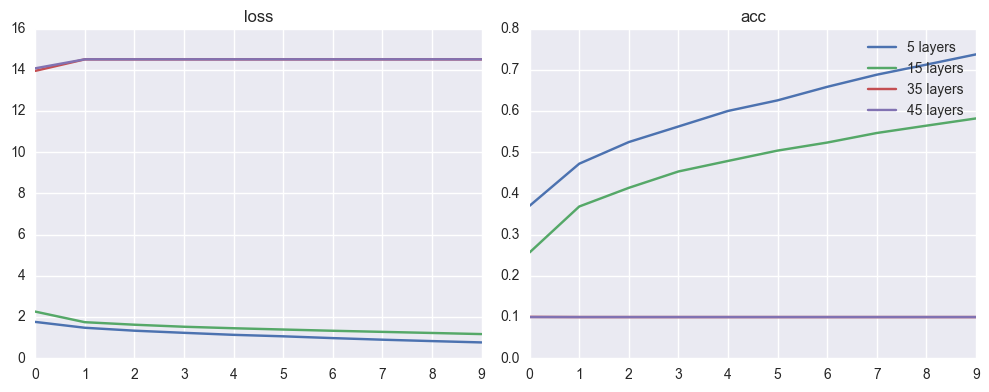

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(nn.history.history['loss'], label='5 layers')
ax1.plot(nn2.history.history['loss'], label='15 layers')
ax1.plot(nn3.history.history['loss'], label='35 layers')
ax1.plot(nn4.history.history['loss'], label='45 layers')
ax1.set_title('loss')
ax2.plot(nn.history.history['acc'], label='5 layers')
ax2.plot(nn2.history.history['acc'], label='15 layers')
ax2.plot(nn3.history.history['acc'], label='35 layers')
ax2.plot(nn4.history.history['acc'], label='45 layers')
ax2.set_title('acc')
plt.legend()
plt.tight_layout()

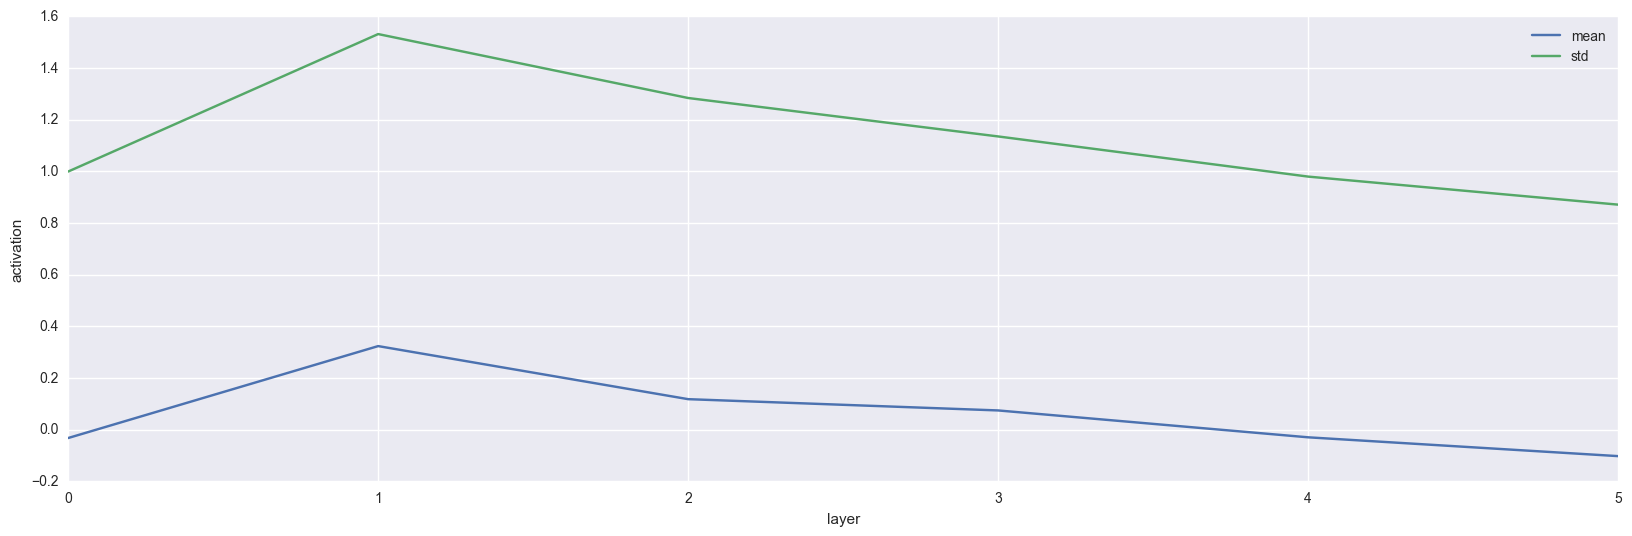

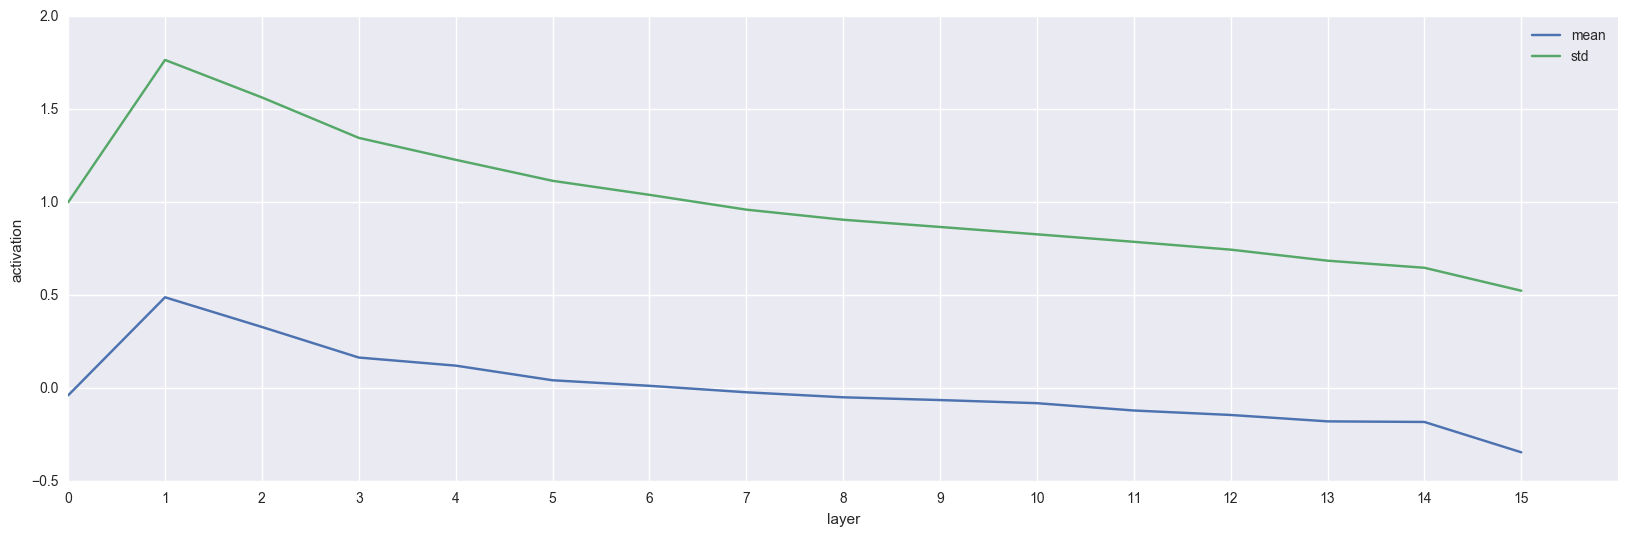

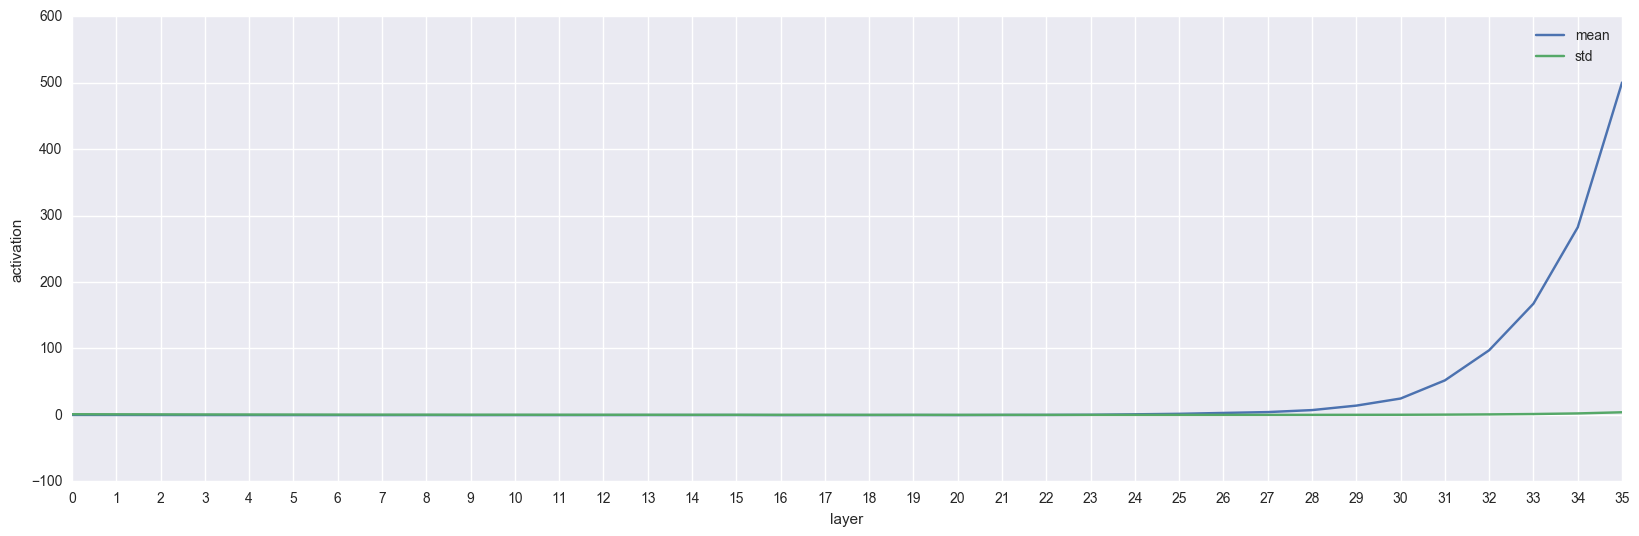

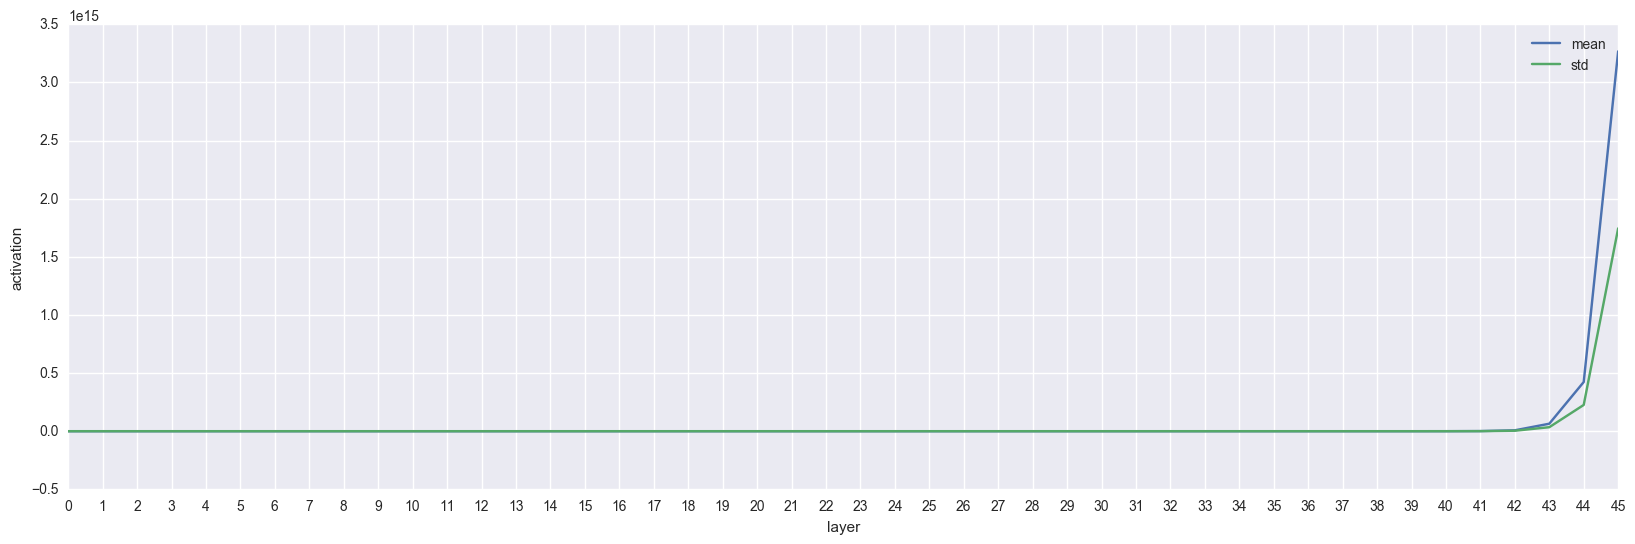

In [32]:
nn.draw_activations()
nn2.draw_activations()
nn3.draw_activations()
nn4.draw_activations()

### Adam(1e-3)

In [33]:
%%time
nn = NN_NP(5, 250, Adam(1e-3))
nn.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1s - loss: 1.7766 - acc: 0.3735 - val_loss: 1.6028 - val_acc: 0.4223
Epoch 2/10
50000/50000 [==============================] - 1s - loss: 1.4785 - acc: 0.4736 - val_loss: 1.4949 - val_acc: 0.4704
Epoch 3/10
50000/50000 [==============================] - 1s - loss: 1.3438 - acc: 0.5235 - val_loss: 1.4336 - val_acc: 0.5002
Epoch 4/10
50000/50000 [==============================] - 1s - loss: 1.2292 - acc: 0.5618 - val_loss: 1.4174 - val_acc: 0.5020
Epoch 5/10
50000/50000 [==============================] - 1s - loss: 1.1261 - acc: 0.5991 - val_loss: 1.4160 - val_acc: 0.5057
Epoch 6/10
50000/50000 [==============================] - 1s - loss: 1.0376 - acc: 0.6322 - val_loss: 1.4099 - val_acc: 0.5104
Epoch 7/10
50000/50000 [==============================] - 1s - loss: 0.9480 - acc: 0.6644 - val_loss: 1.4311 - val_acc: 0.5215
Epoch 8/10
50000/50000 [==============================] - 1s 

In [34]:
%%time
nn2 = NN_NP(15, 250, Adam(1e-3))
nn2.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2s - loss: 1.9341 - acc: 0.2984 - val_loss: 1.7466 - val_acc: 0.3779
Epoch 2/10
50000/50000 [==============================] - 2s - loss: 1.6680 - acc: 0.4027 - val_loss: 1.6161 - val_acc: 0.4154
Epoch 3/10
50000/50000 [==============================] - 2s - loss: 1.5380 - acc: 0.4530 - val_loss: 1.5497 - val_acc: 0.4535
Epoch 4/10
50000/50000 [==============================] - 2s - loss: 1.4527 - acc: 0.4824 - val_loss: 1.5033 - val_acc: 0.4632
Epoch 5/10
50000/50000 [==============================] - 2s - loss: 1.3692 - acc: 0.5156 - val_loss: 1.4674 - val_acc: 0.4857
Epoch 6/10
50000/50000 [==============================] - 2s - loss: 1.3014 - acc: 0.5368 - val_loss: 1.4774 - val_acc: 0.4892
Epoch 7/10
50000/50000 [==============================] - 2s - loss: 1.2435 - acc: 0.5633 - val_loss: 1.4140 - val_acc: 0.5091
Epoch 8/10
50000/50000 [==============================] - 2s 

In [35]:
%%time
nn3 = NN_NP(35, 250, Adam(1e-3))
nn3.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s - loss: 2.2001 - acc: 0.1815 - val_loss: 2.0086 - val_acc: 0.2469
Epoch 2/10
50000/50000 [==============================] - 3s - loss: 1.9373 - acc: 0.2639 - val_loss: 1.8680 - val_acc: 0.2991
Epoch 3/10
50000/50000 [==============================] - 3s - loss: 1.8574 - acc: 0.2995 - val_loss: 1.8198 - val_acc: 0.3189
Epoch 4/10
50000/50000 [==============================] - 3s - loss: 1.7772 - acc: 0.3415 - val_loss: 1.7481 - val_acc: 0.3685
Epoch 5/10
50000/50000 [==============================] - 3s - loss: 1.7106 - acc: 0.3722 - val_loss: 1.6995 - val_acc: 0.3915
Epoch 6/10
50000/50000 [==============================] - 3s - loss: 1.6803 - acc: 0.3887 - val_loss: 1.6628 - val_acc: 0.4022
Epoch 7/10
50000/50000 [==============================] - 3s - loss: 1.6322 - acc: 0.4132 - val_loss: 1.6138 - val_acc: 0.4187
Epoch 8/10
50000/50000 [==============================] - 3s 

In [36]:
%%time
nn4 = NN_NP(45, 250, Adam(1e-3))
nn4.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s - loss: 2.3269 - acc: 0.1253 - val_loss: 2.2102 - val_acc: 0.1718
Epoch 2/10
50000/50000 [==============================] - 4s - loss: 2.2095 - acc: 0.1623 - val_loss: 2.1826 - val_acc: 0.1614
Epoch 3/10
50000/50000 [==============================] - 4s - loss: 2.2308 - acc: 0.1494 - val_loss: 2.2230 - val_acc: 0.1615
Epoch 4/10
50000/50000 [==============================] - 4s - loss: 2.2522 - acc: 0.1471 - val_loss: 2.3220 - val_acc: 0.0934
Epoch 5/10
50000/50000 [==============================] - 4s - loss: 2.2166 - acc: 0.1560 - val_loss: 2.1897 - val_acc: 0.1620
Epoch 6/10
50000/50000 [==============================] - 4s - loss: 2.1644 - acc: 0.1758 - val_loss: 2.1358 - val_acc: 0.1822
Epoch 7/10
50000/50000 [==============================] - 4s - loss: 2.1358 - acc: 0.1826 - val_loss: 2.1213 - val_acc: 0.1894
Epoch 8/10
50000/50000 [==============================] - 4s 

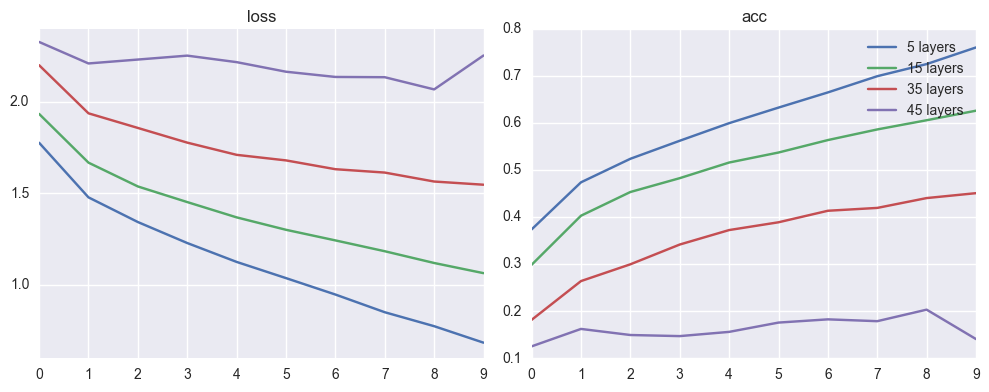

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(nn.history.history['loss'], label='5 layers')
ax1.plot(nn2.history.history['loss'], label='15 layers')
ax1.plot(nn3.history.history['loss'], label='35 layers')
ax1.plot(nn4.history.history['loss'], label='45 layers')
ax1.set_title('loss')
ax2.plot(nn.history.history['acc'], label='5 layers')
ax2.plot(nn2.history.history['acc'], label='15 layers')
ax2.plot(nn3.history.history['acc'], label='35 layers')
ax2.plot(nn4.history.history['acc'], label='45 layers')
ax2.set_title('acc')
plt.legend()
plt.tight_layout()

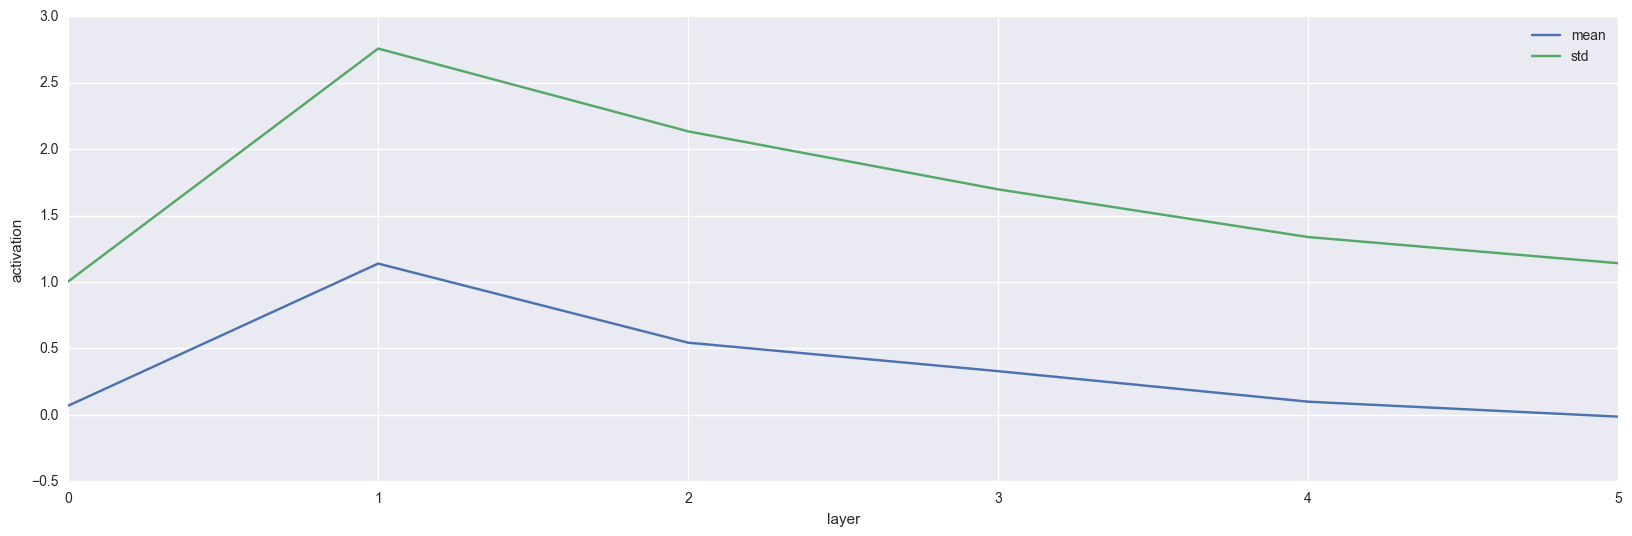

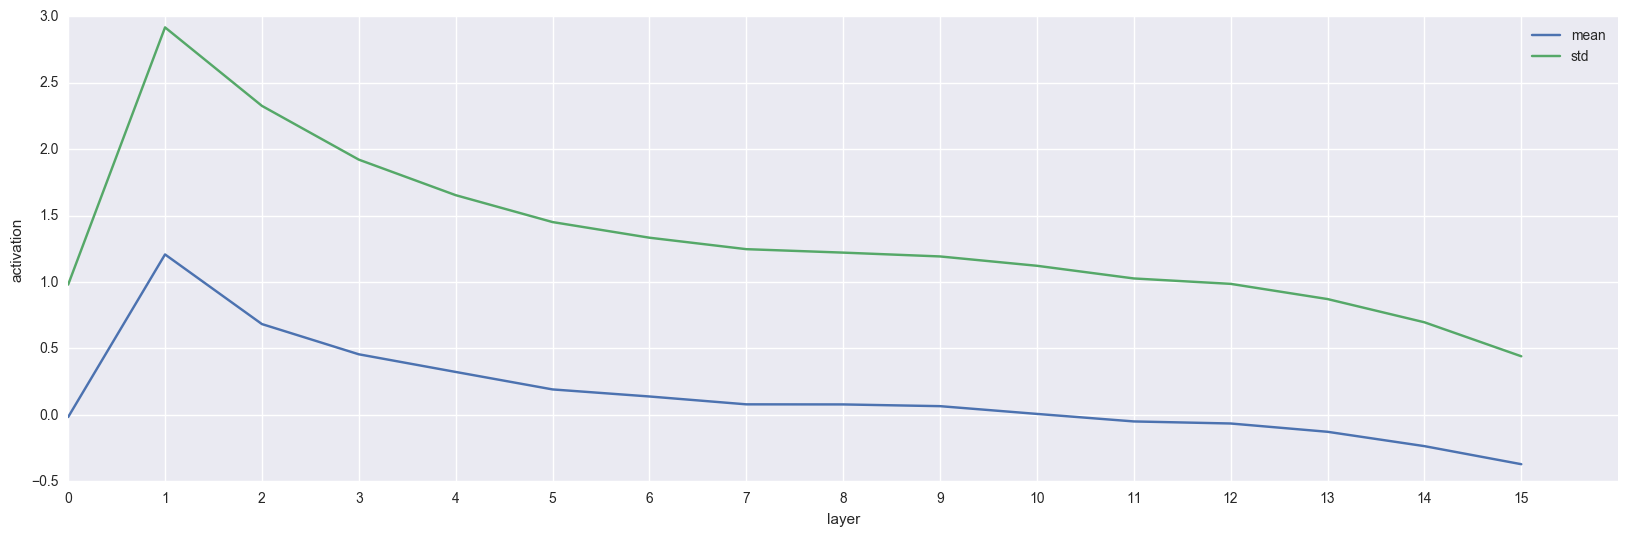

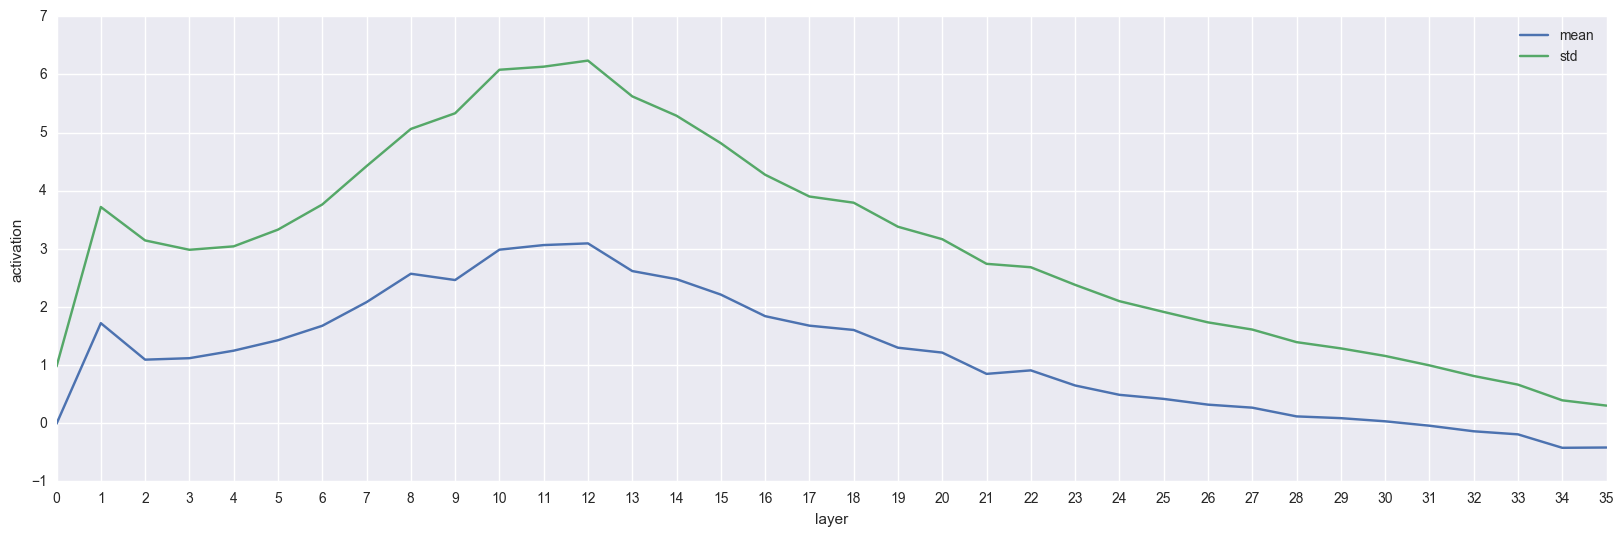

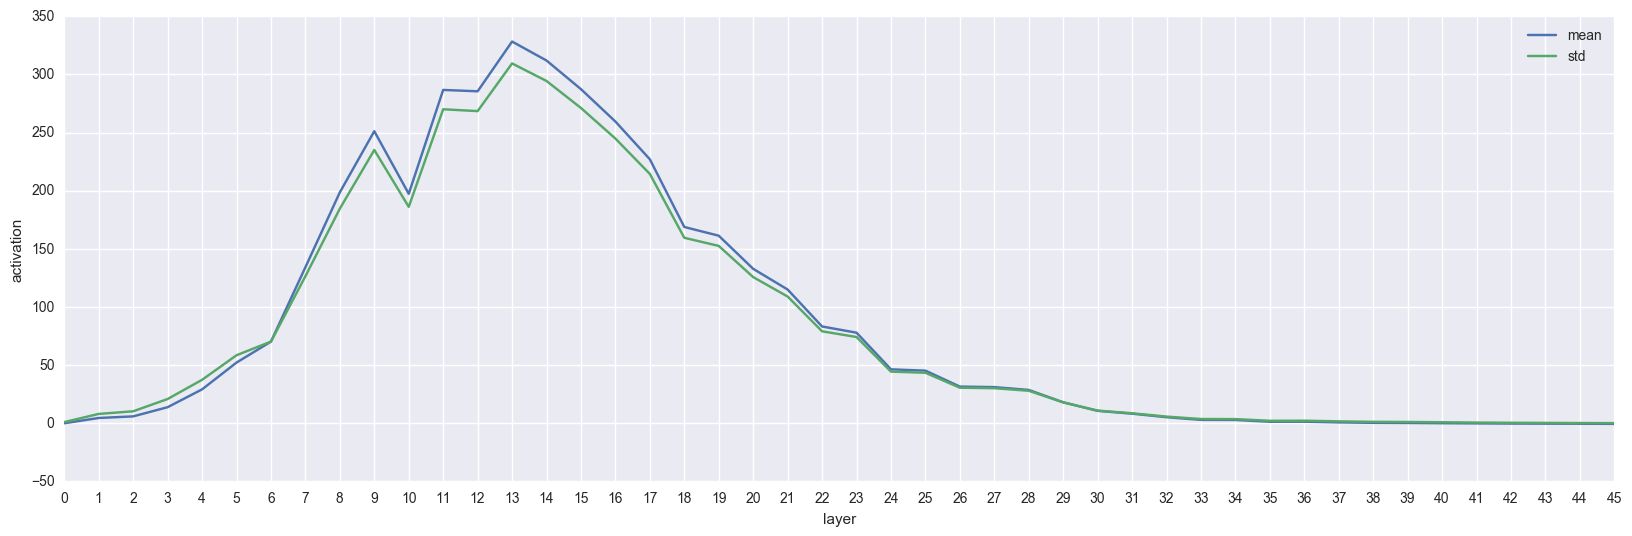

In [38]:
nn.draw_activations()
nn2.draw_activations()
nn3.draw_activations()
nn4.draw_activations()

### Adam(1e-4)

In [39]:
%%time
nn = NN_NP(5, 250, Adam(1e-4))
nn.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1s - loss: 1.8650 - acc: 0.3296 - val_loss: 1.6683 - val_acc: 0.4013
Epoch 2/10
50000/50000 [==============================] - 1s - loss: 1.5501 - acc: 0.4488 - val_loss: 1.5540 - val_acc: 0.4544
Epoch 3/10
50000/50000 [==============================] - 1s - loss: 1.4112 - acc: 0.4996 - val_loss: 1.4958 - val_acc: 0.4704
Epoch 4/10
50000/50000 [==============================] - 1s - loss: 1.3123 - acc: 0.5375 - val_loss: 1.4675 - val_acc: 0.4773
Epoch 5/10
50000/50000 [==============================] - 1s - loss: 1.2262 - acc: 0.5686 - val_loss: 1.4414 - val_acc: 0.4955
Epoch 6/10
50000/50000 [==============================] - 1s - loss: 1.1507 - acc: 0.5972 - val_loss: 1.4267 - val_acc: 0.4985
Epoch 7/10
50000/50000 [==============================] - 1s - loss: 1.0837 - acc: 0.6223 - val_loss: 1.4280 - val_acc: 0.5022
Epoch 8/10
50000/50000 [==============================] - 1s 

In [40]:
%%time
nn2 = NN_NP(15, 250, Adam(1e-4))
nn2.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2s - loss: 1.9627 - acc: 0.2870 - val_loss: 1.7610 - val_acc: 0.3656
Epoch 2/10
50000/50000 [==============================] - 2s - loss: 1.6657 - acc: 0.4010 - val_loss: 1.6377 - val_acc: 0.4122
Epoch 3/10
50000/50000 [==============================] - 2s - loss: 1.5353 - acc: 0.4506 - val_loss: 1.5951 - val_acc: 0.4360
Epoch 4/10
50000/50000 [==============================] - 2s - loss: 1.4395 - acc: 0.4872 - val_loss: 1.5508 - val_acc: 0.4472
Epoch 5/10
50000/50000 [==============================] - 2s - loss: 1.3513 - acc: 0.5191 - val_loss: 1.5354 - val_acc: 0.4612
Epoch 6/10
50000/50000 [==============================] - 2s - loss: 1.2701 - acc: 0.5508 - val_loss: 1.5517 - val_acc: 0.4561
Epoch 7/10
50000/50000 [==============================] - 2s - loss: 1.1937 - acc: 0.5775 - val_loss: 1.5445 - val_acc: 0.4646
Epoch 8/10
50000/50000 [==============================] - 2s 

In [41]:
%%time
nn3 = NN_NP(35, 250, Adam(1e-4))
nn3.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s - loss: 2.0393 - acc: 0.2393 - val_loss: 1.8380 - val_acc: 0.3252
Epoch 2/10
50000/50000 [==============================] - 3s - loss: 1.7751 - acc: 0.3508 - val_loss: 1.7417 - val_acc: 0.3777
Epoch 3/10
50000/50000 [==============================] - 3s - loss: 1.6549 - acc: 0.4004 - val_loss: 1.6665 - val_acc: 0.3983
Epoch 4/10
50000/50000 [==============================] - 3s - loss: 1.5735 - acc: 0.4343 - val_loss: 1.6570 - val_acc: 0.4064
Epoch 5/10
50000/50000 [==============================] - 3s - loss: 1.5053 - acc: 0.4601 - val_loss: 1.5979 - val_acc: 0.4397
Epoch 6/10
50000/50000 [==============================] - 3s - loss: 1.4385 - acc: 0.4863 - val_loss: 1.5796 - val_acc: 0.4446
Epoch 7/10
50000/50000 [==============================] - 3s - loss: 1.3796 - acc: 0.5086 - val_loss: 1.5794 - val_acc: 0.4493
Epoch 8/10
50000/50000 [==============================] - 3s 

In [42]:
%%time
nn4 = NN_NP(45, 250, Adam(1e-4))
nn4.fit(1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s - loss: 2.0961 - acc: 0.1948 - val_loss: 1.9364 - val_acc: 0.2573
Epoch 2/10
50000/50000 [==============================] - 4s - loss: 1.8561 - acc: 0.2896 - val_loss: 1.8110 - val_acc: 0.3198
Epoch 3/10
50000/50000 [==============================] - 4s - loss: 1.7519 - acc: 0.3359 - val_loss: 1.7416 - val_acc: 0.3525
Epoch 4/10
50000/50000 [==============================] - 4s - loss: 1.6814 - acc: 0.3738 - val_loss: 1.7028 - val_acc: 0.3749
Epoch 5/10
50000/50000 [==============================] - 4s - loss: 1.6174 - acc: 0.4082 - val_loss: 1.6594 - val_acc: 0.4011
Epoch 6/10
50000/50000 [==============================] - 4s - loss: 1.5501 - acc: 0.4376 - val_loss: 1.6508 - val_acc: 0.4126
Epoch 7/10
50000/50000 [==============================] - 4s - loss: 1.4954 - acc: 0.4608 - val_loss: 1.6340 - val_acc: 0.4258
Epoch 8/10
50000/50000 [==============================] - 4s 

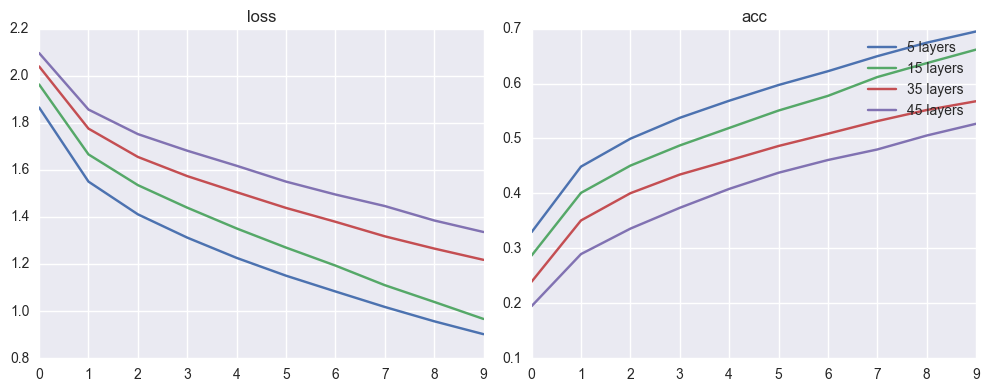

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(nn.history.history['loss'], label='5 layers')
ax1.plot(nn2.history.history['loss'], label='15 layers')
ax1.plot(nn3.history.history['loss'], label='35 layers')
ax1.plot(nn4.history.history['loss'], label='45 layers')
ax1.set_title('loss')
ax2.plot(nn.history.history['acc'], label='5 layers')
ax2.plot(nn2.history.history['acc'], label='15 layers')
ax2.plot(nn3.history.history['acc'], label='35 layers')
ax2.plot(nn4.history.history['acc'], label='45 layers')
ax2.set_title('acc')
plt.legend()
plt.tight_layout()

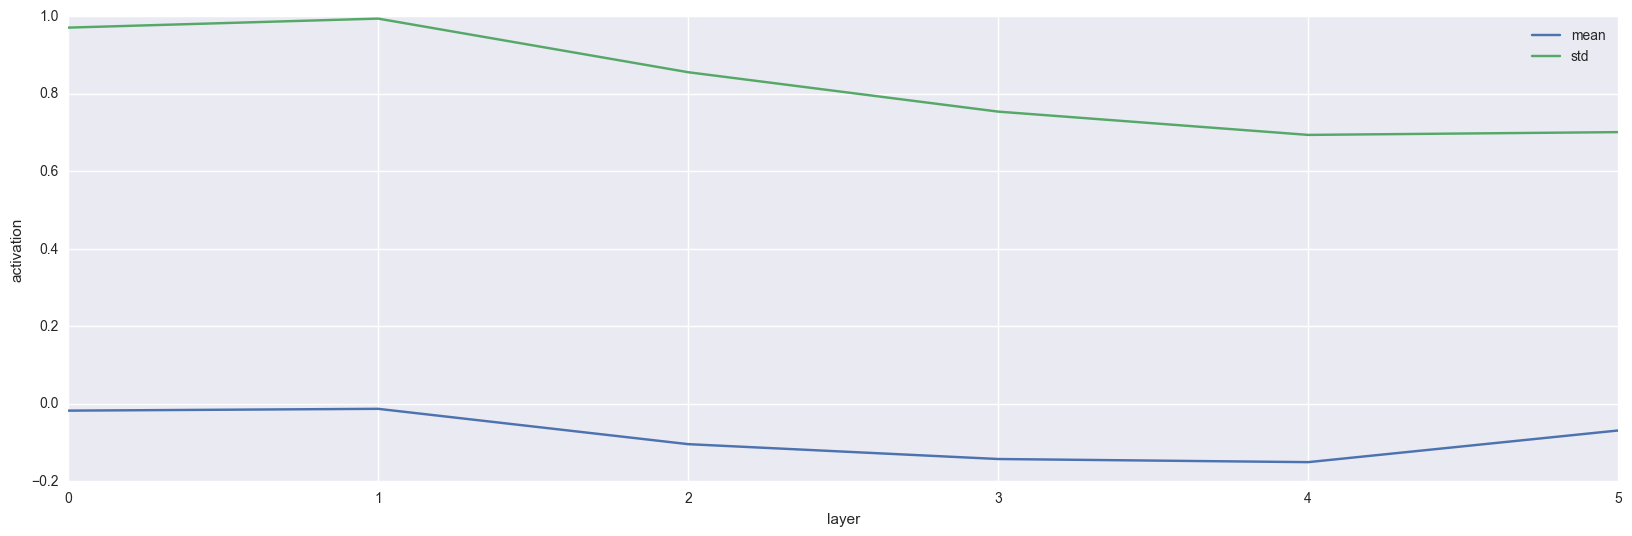

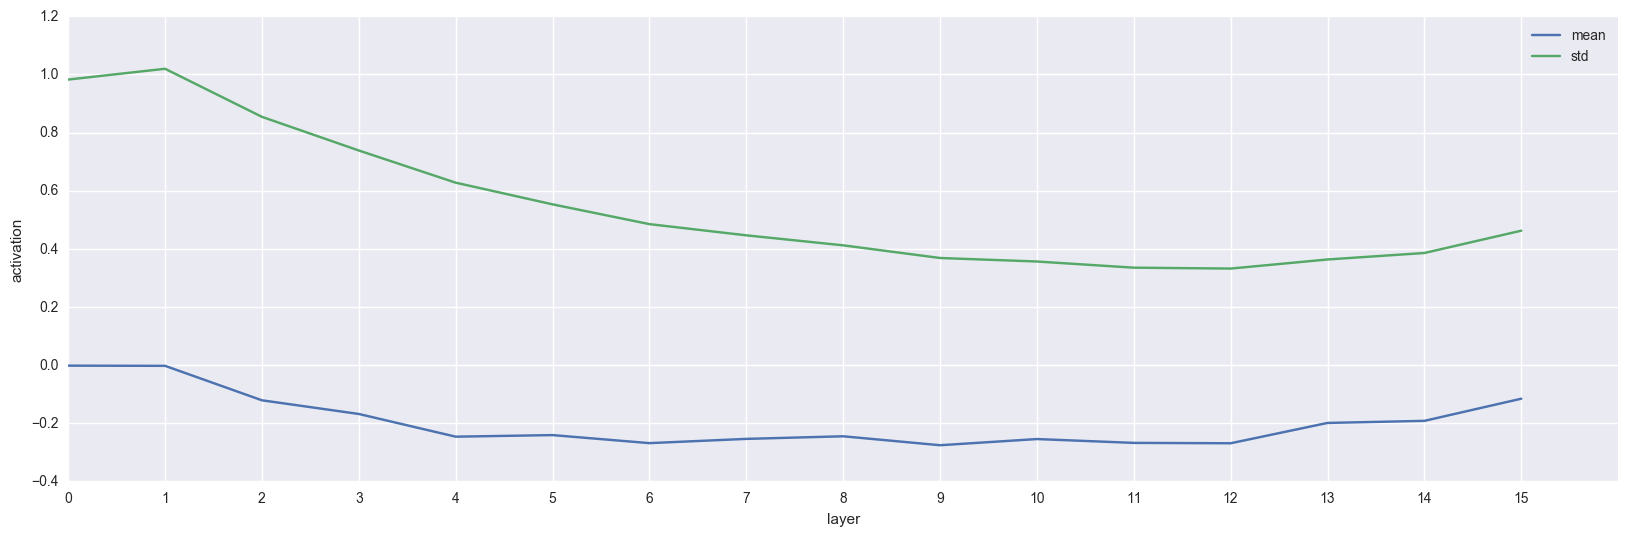

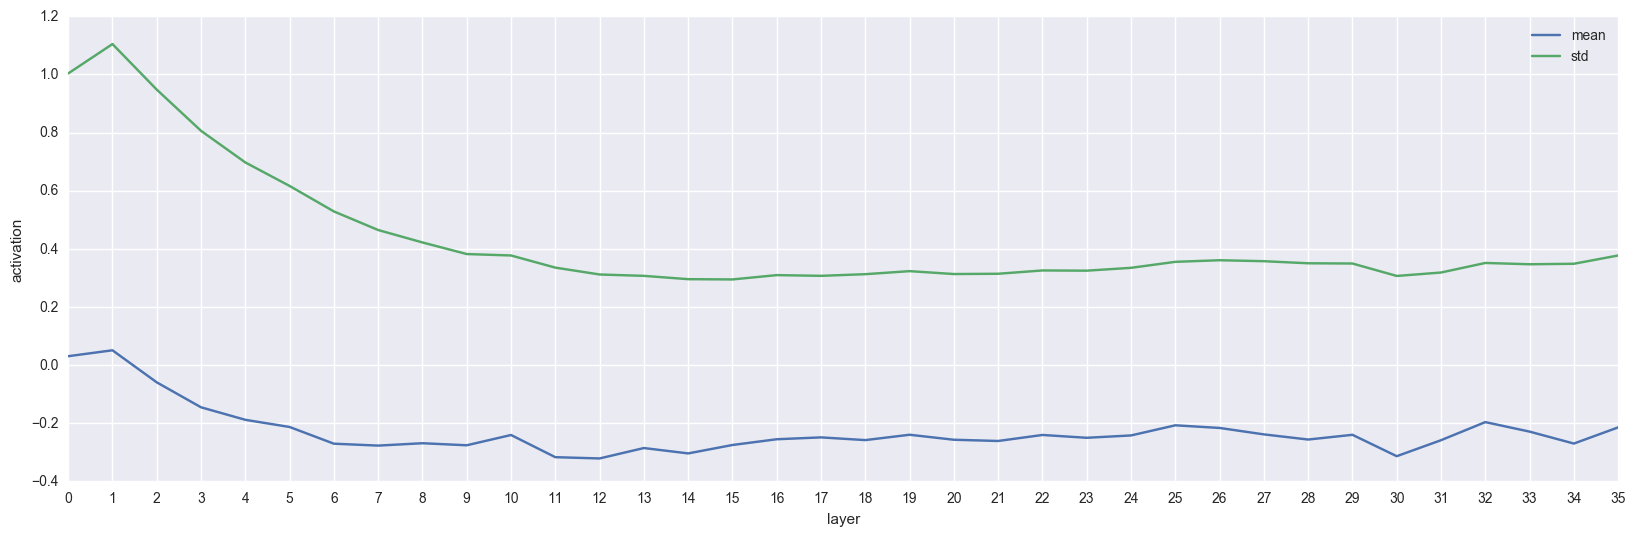

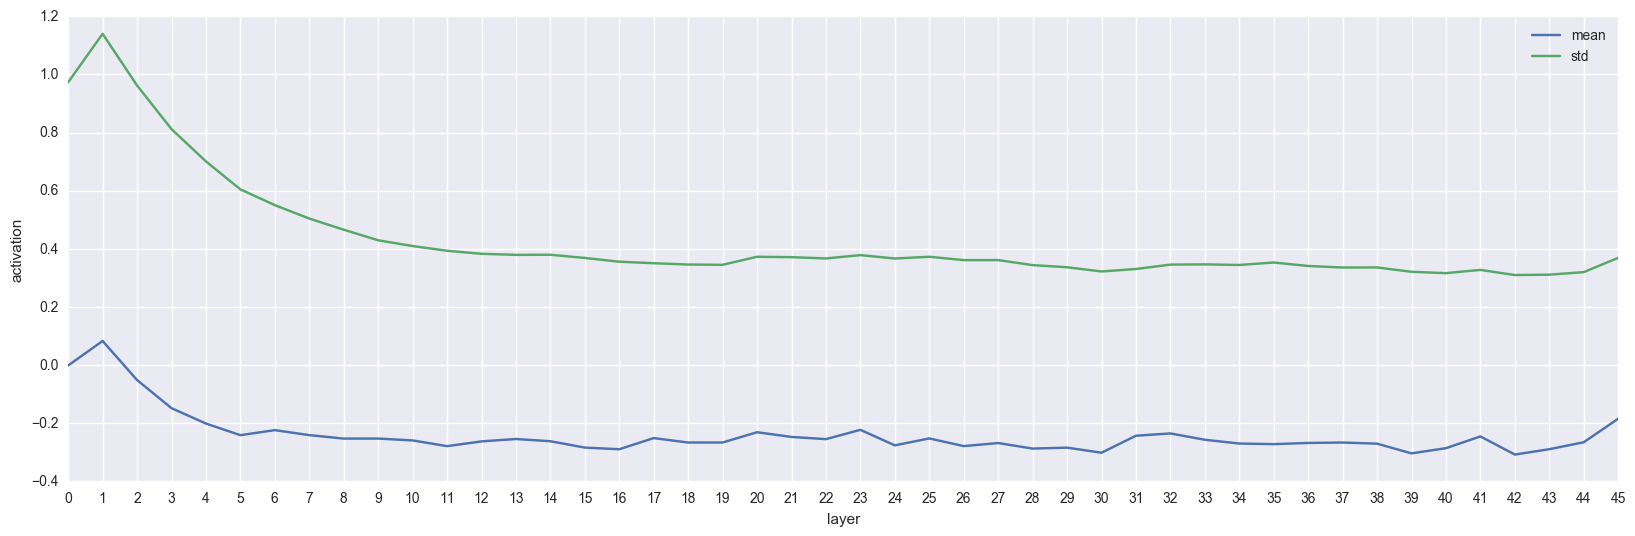

In [44]:
nn.draw_activations()
nn2.draw_activations()
nn3.draw_activations()
nn4.draw_activations()